<a href="https://colab.research.google.com/github/shahidzk1/HP_OPT/blob/main/Higgs_challenge/HiggsBosonChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Higgs Boson Challenge
In this code, the Kaggle data from the higgs boson challenge will be taken and multiple algorithms will be tried to see their performances. The TPE algorithm will be used to find the hyperparameters. The model perfromance will be judged on the AUC score on the test data. The usefullness of the variables will be shown with Shapley method.

To run this colab, kindly use the GPU option in the runtime.

Created by Shahid Khan at the university of Geneva, Switzerland.

In [1]:
# The following packages are required for this notebook but they are not pre-installed on colab
%%capture
!pip install -q kaggle
!pip install optuna
!pip install optuna-integration
#the following lines imports a class from github
!git clone https://github.com/shahidzk1/HP_OPT.git
%cd HP_OPT
!git pull origin main
!pip install -r requirements.txt
!python setup.py install
!pip install shap

#Importing the data
Create a Kaggle account and visit the link (https://www.kaggle.com/competitions/higgs-boson/data). Accept the challenge. The following image shows a screenshot of the "Join the competition". 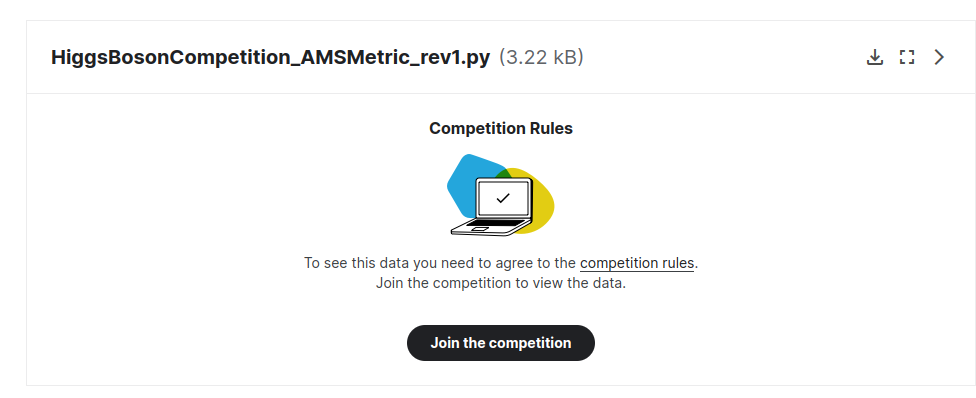


Visit your Kaggle account  (https://www.kaggle.com/username/account)
and create a New API Token.
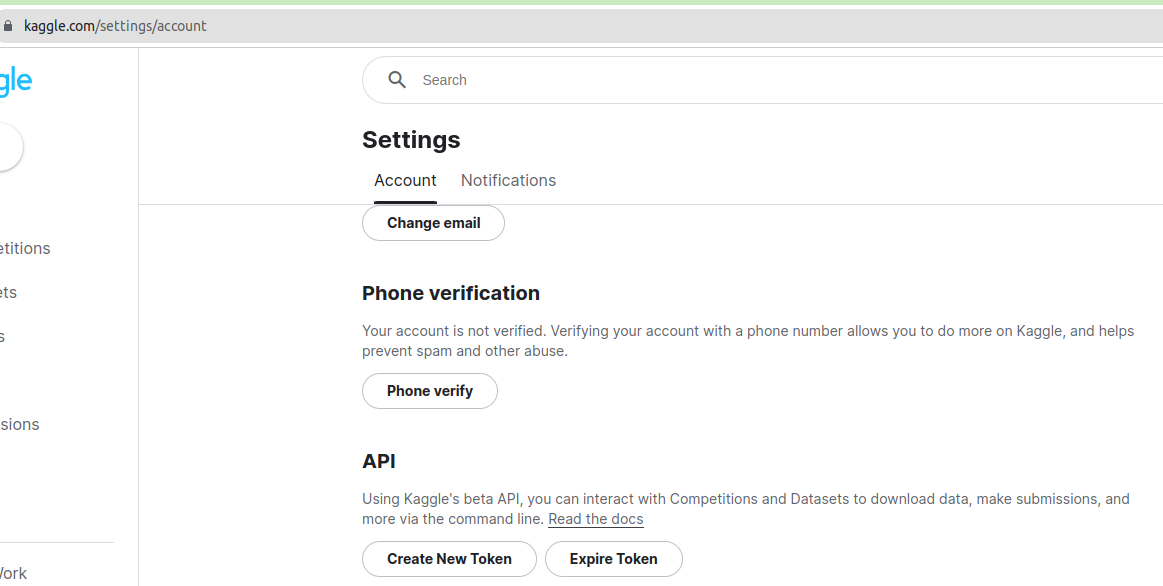
 Download it on your personal laptop and then use that .json file in the following line.

In [2]:
from google.colab import files
#Choose file should be the downloaded .json file from kaggle
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shahidzafarkhan","key":"198129d0833bb09a6a27f2b2558a0053"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c higgs-boson --force
!unzip higgs-boson.zip
!ls

 90% 49.0M/54.3M [00:00<00:00, 100MB/s]
100% 54.3M/54.3M [00:00<00:00, 114MB/s]
Archive:  higgs-boson.zip
  inflating: HiggsBosonCompetition_AMSMetric_rev1.py  
  inflating: random_submission.zip   
  inflating: test.zip                
  inflating: training.zip            
build					 HP_OPT_class.egg-info	requirements.txt
dist					 kaggle.json		setup.py
HiggsBosonChallenge.ipynb		 LICENSE		test.zip
HiggsBosonCompetition_AMSMetric_rev1.py  Makefile		training.zip
higgs-boson.zip				 random_submission.zip
HP_OPT_class				 README.md


#Importing libraries
The following libraries will be used in this notebook

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import gc
from sklearn.metrics import roc_curve, auc
from HP_OPT_class import HP_OPT_class_code, plot_tools
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import shap
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.cuda.amp as amp

In [5]:
df_train = pd.read_csv('training.zip', compression='zip')
df_test = pd.read_csv('test.zip', compression='zip')

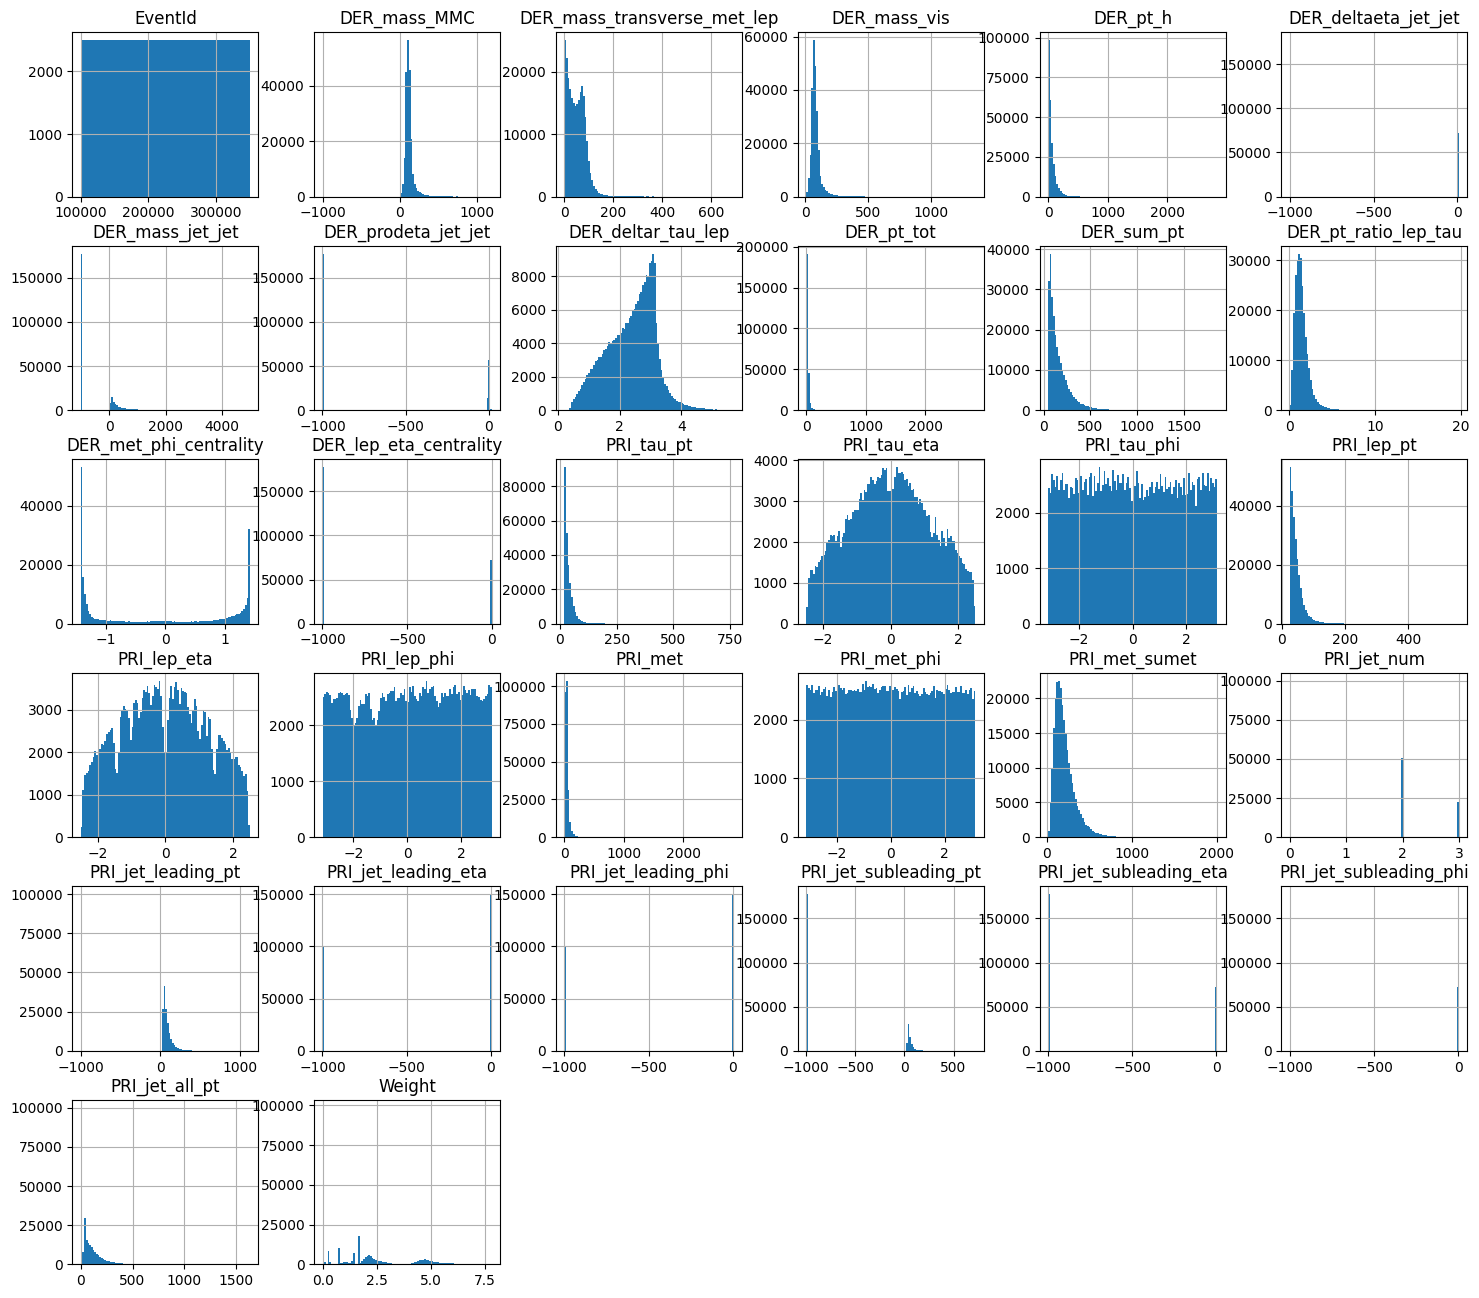

In [6]:
df_train.hist(bins=100, figsize=(18,16))
plt.show()

<Axes: >

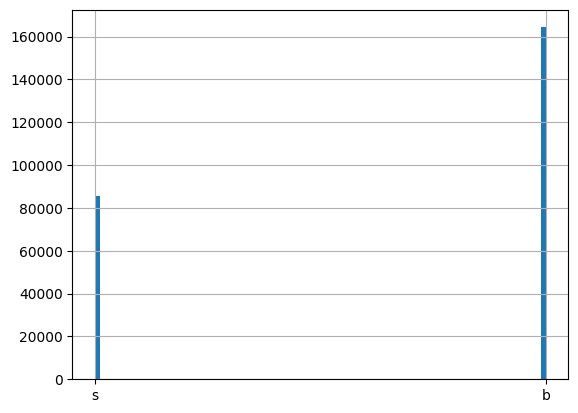

In [7]:
df_train['Label'].hist(bins=100)

The labels show that there are two classes and they are imbalanced so let's try with the given classes ratio

In [8]:
new_cuts =['DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']

x = df_train[new_cuts].copy()
y =df_train['Label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=324, stratify=y)# create a train and a test data set, the train-test will be used for HPO
del x, y


encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
dummy_y_train = tf.keras.utils.to_categorical(encoded_Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = tf.keras.utils.to_categorical(encoded_Y)
encoded_Y_test = encoder.transform(y_test)
dummy_y_test = tf.keras.utils.to_categorical(encoded_Y_test)

# Three different algorithms
The Multi-layered perceptron will be used as the base model and XGBoost and Convolutional neural networs will be used as alternative models.

##Hyperparameters optimization
The [Optuna](https://optuna.org/) library is used to optimize the hyper-parameters with its inbuilt TPE algorithm. The library's optimize function calls NUMBER_TRIALS number of trials. Each trial has EPOCHS number of epochs.

## Neural networks HP optimization
The number of layers, number of neurons and the learning rate will be searched

In [9]:
if __name__ == "__main__":
    # Load your dataset and labels here
    BATCHSIZE = 1024
    transformer_hyp_par = {
        'd_model': (64, 256),
        'num_heads': (2, 8),
        'num_layers': (2, 15),
        'dropout': (0.1, 0.5),
        'weight_decay': (1e-6, 1e-3),
        'l1_regularization': (1e-6, 1e-3),
        'learning_rate': (1e-5, 1e-2)
    }
    keras_hyperparameters = {
            'n_layers': (2, 15),
            'n_units': (1000, 3000),
            'learning_rate': (1e-5, 1e-1)
            # Add more Keras hyperparameters here as needed
        }

    xgboost_hyperparameters = {
        'n_estimators': (100, 1000),
        'alpha': (2, 30),
        'gamma': (0, 1),
        'learning_rate': (0.01, 1),
        'max_depth': (0, 10)
        # Add more XGBoost hyperparameters here as needed
    }

    cnn_hyperparameters = {
        'filters': [32, 64],
        'kernel_size': [3, 5],
        'strides': [1, 2],
        'n_conv_layers_min': 0,
        'n_conv_layers_max': 3,
        'dropout_min': 0.0,
        'dropout_max': 0.5,
        'n_layers_min': 2,
        'n_layers_max': 22,
        'n_units_min': 1000,
        'n_units_max': 1500,
        'learning_rate_min': 1e-5,
        'learning_rate_max': 1e-1
        # Define CNN hyperparameters here
    }
    y_train_new = y_train.replace('s', 1, regex=True)
    y_train_new = y_train_new.replace('b', 0, regex=True)
    optimizer = HP_OPT_class_code.HP_OPT(x_train, y_train_new, batch_size=BATCHSIZE, n_trials=10,
                              mlp_hyp_par=keras_hyperparameters, xgb_hyp_para=xgboost_hyperparameters,
                              transformer_hyp_par=transformer_hyp_par, num_classes=len(np.unique(y_train_new)))


    # Optimize the Keras model
    study_keras = optimizer.optimize("keras")

[I 2023-11-24 15:25:15,769] A new study created in memory with name: no-name-253115e4-9806-4ae6-8c2f-9889820ba85f


Epoch 1/10
 6/88 [=>............................] - ETA: 7s - loss: 82381251758744666112.0000 - auc: 0.5166

88/88 [==============================] - 18s 87ms/step - loss: 5696691239542325248.0000 - auc: 0.5031 - val_loss: 11678566907379712.0000 - val_auc: 0.6539
Epoch 2/10
88/88 [==============================] - 7s 80ms/step - loss: 889627850309632.0000 - auc: 0.5745 - val_loss: 42274176106496.0000 - val_auc: 0.3461
Epoch 3/10
88/88 [==============================] - 8s 80ms/step - loss: 27015352881774592.0000 - auc: 0.5398 - val_loss: 833244190736384.0000 - val_auc: 0.6539
Epoch 4/10
88/88 [==============================] - 7s 82ms/step - loss: 1467653273157632.0000 - auc: 0.5515 - val_loss: 200474829520896.0000 - val_auc: 0.6539
Epoch 5/10
88/88 [==============================] - 8s 82ms/step - loss: 89684621393920.0000 - auc: 0.5376 - val_loss: 2803770589184.0000 - val_auc: 0.6541
Epoch 6/10
88/88 [==============================] - 8s 83ms/step - loss: 636352724992.0000 - auc: 0.5539 - val_loss: 14183181312.0000 - val_auc: 0.6695
Epoch 7/10
88/88 [==============================] - 8s 82m

[I 2023-11-24 15:26:49,656] Trial 0 finished with value: 0.3426799774169922 and parameters: {'n_layers': 13, 'n_units_l0': 2375, 'n_units_l1': 1012, 'n_units_l2': 1750, 'n_units_l3': 1531, 'n_units_l4': 1708, 'n_units_l5': 1738, 'n_units_l6': 2803, 'n_units_l7': 2518, 'n_units_l8': 2551, 'n_units_l9': 1065, 'n_units_l10': 1574, 'n_units_l11': 2899, 'n_units_l12': 1675, 'learning_rate': 0.05826587868311696}. Best is trial 0 with value: 0.3426799774169922.


Epoch 1/10
 6/88 [=>............................] - ETA: 8s - loss: 6248921328254976.0000 - auc: 0.5244

88/88 [==============================] - 14s 94ms/step - loss: 426793920102400.0000 - auc: 0.5374 - val_loss: 22454743040.0000 - val_auc: 0.6539
Epoch 2/10
88/88 [==============================] - 9s 93ms/step - loss: 863104320.0000 - auc: 0.5496 - val_loss: 15381273.0000 - val_auc: 0.3461
Epoch 3/10
88/88 [==============================] - 9s 90ms/step - loss: 1886356.7500 - auc: 0.5420 - val_loss: 87000.8672 - val_auc: 0.6539
Epoch 4/10
88/88 [==============================] - 8s 91ms/step - loss: 151005.9688 - auc: 0.5547 - val_loss: 445628.6250 - val_auc: 0.6539
Epoch 5/10
88/88 [==============================] - 8s 90ms/step - loss: 8391859200.0000 - auc: 0.5203 - val_loss: 193462304768.0000 - val_auc: 0.6539
Epoch 6/10
88/88 [==============================] - 8s 90ms/step - loss: 79791833088.0000 - auc: 0.5203 - val_loss: 9921889280.0000 - val_auc: 0.6539
Epoch 7/10
88/88 [==============================] - 8s 91ms/step - loss: 63096553472.0000 - auc: 0.5197 - val_loss: 1001587609

[I 2023-11-24 15:29:17,738] Trial 1 finished with value: 0.6925362348556519 and parameters: {'n_layers': 14, 'n_units_l0': 1018, 'n_units_l1': 2932, 'n_units_l2': 1466, 'n_units_l3': 2547, 'n_units_l4': 2282, 'n_units_l5': 2631, 'n_units_l6': 2307, 'n_units_l7': 1061, 'n_units_l8': 1868, 'n_units_l9': 1956, 'n_units_l10': 2284, 'n_units_l11': 1132, 'n_units_l12': 1363, 'n_units_l13': 2110, 'learning_rate': 0.02082430067003804}. Best is trial 1 with value: 0.6925362348556519.


Epoch 1/10
 6/88 [=>............................] - ETA: 6s - loss: 9459430319980544.0000 - auc: 0.4779 

88/88 [==============================] - 11s 73ms/step - loss: 691744144359424.0000 - auc: 0.5155 - val_loss: 15199367168.0000 - val_auc: 0.6539
Epoch 2/10
88/88 [==============================] - 6s 69ms/step - loss: 403527696384.0000 - auc: 0.5032 - val_loss: 2573017546752.0000 - val_auc: 0.3461
Epoch 3/10
88/88 [==============================] - 7s 71ms/step - loss: 14897753620480.0000 - auc: 0.4587 - val_loss: 153629491200.0000 - val_auc: 0.3461
Epoch 4/10
88/88 [==============================] - 6s 69ms/step - loss: 14564668211200.0000 - auc: 0.4857 - val_loss: 245214347264.0000 - val_auc: 0.3461
Epoch 5/10
88/88 [==============================] - ETA: 0s - loss: 1439479889920.0000 - auc: 0.5180

[I 2023-11-24 15:29:55,280] Trial 2 pruned. Trial was pruned at epoch 4.


Epoch 1/10
 4/88 [>.............................] - ETA: 1s - loss: 369.7184 - auc: 0.5039

88/88 [==============================] - 4s 22ms/step - loss: 18.1489 - auc: 0.6946 - val_loss: 0.5399 - val_auc: 0.8032
Epoch 2/10
88/88 [==============================] - 2s 22ms/step - loss: 0.5362 - auc: 0.8038 - val_loss: 0.5167 - val_auc: 0.8222
Epoch 3/10
88/88 [==============================] - 2s 23ms/step - loss: 0.5013 - auc: 0.8342 - val_loss: 0.4955 - val_auc: 0.8436
Epoch 4/10
88/88 [==============================] - 2s 20ms/step - loss: 0.4732 - auc: 0.8568 - val_loss: 0.4743 - val_auc: 0.8561
Epoch 5/10
88/88 [==============================] - 2s 20ms/step - loss: 0.4604 - auc: 0.8647 - val_loss: 0.4833 - val_auc: 0.8561
Epoch 6/10
88/88 [==============================] - 2s 19ms/step - loss: 0.4525 - auc: 0.8696 - val_loss: 0.4384 - val_auc: 0.8786
Epoch 7/10
88/88 [==============================] - 2s 20ms/step - loss: 0.4481 - auc: 0.8725 - val_loss: 0.4370 - val_auc: 0.8796
Epoch 8/10
88/88 [==============================] - 2s 20ms/step - loss: 0.4422 - auc: 0.8758

[I 2023-11-24 15:30:45,322] Trial 3 finished with value: 0.8820822238922119 and parameters: {'n_layers': 5, 'n_units_l0': 1033, 'n_units_l1': 1241, 'n_units_l2': 1085, 'n_units_l3': 1917, 'n_units_l4': 1212, 'learning_rate': 0.0009713276927256544}. Best is trial 3 with value: 0.8820822238922119.


Epoch 1/10
 6/88 [=>............................] - ETA: 7s - loss: 12577863.0000 - auc: 0.5276

88/88 [==============================] - 14s 87ms/step - loss: 866542.1875 - auc: 0.5137 - val_loss: 3.5443 - val_auc: 0.6570
Epoch 2/10
88/88 [==============================] - ETA: 0s - loss: 31.9625 - auc: 0.5573

[I 2023-11-24 15:31:07,911] Trial 4 pruned. Trial was pruned at epoch 1.


Epoch 1/10
 6/88 [=>............................] - ETA: 5s - loss: 8929141.0000 - auc: 0.4790 

88/88 [==============================] - 9s 61ms/step - loss: 609682.4375 - auc: 0.5192 - val_loss: 2.8843 - val_auc: 0.5827
Epoch 2/10
87/88 [============================>.] - ETA: 0s - loss: 15.0713 - auc: 0.5532

[I 2023-11-24 15:31:22,959] Trial 5 pruned. Trial was pruned at epoch 1.


Epoch 1/10
88/88 [==============================] - 4s 17ms/step - loss: 10.9010 - auc: 0.6502 - val_loss: 1.9933 - val_auc: 0.6478
Epoch 2/10
86/88 [============================>.] - ETA: 0s - loss: 1.9592 - auc: 0.6988

[I 2023-11-24 15:31:35,710] Trial 6 pruned. Trial was pruned at epoch 1.


Epoch 1/10
 6/88 [=>............................] - ETA: 9s - loss: 0.8562 - auc: 0.6152

88/88 [==============================] - 16s 113ms/step - loss: 0.5657 - auc: 0.7830 - val_loss: 0.5467 - val_auc: 0.7866
Epoch 2/10
88/88 [==============================] - 10s 110ms/step - loss: 0.4921 - auc: 0.8409 - val_loss: 0.4683 - val_auc: 0.8590
Epoch 3/10
88/88 [==============================] - 10s 111ms/step - loss: 0.4746 - auc: 0.8543 - val_loss: 0.4678 - val_auc: 0.8589
Epoch 4/10
88/88 [==============================] - 10s 110ms/step - loss: 0.4527 - auc: 0.8689 - val_loss: 0.4503 - val_auc: 0.8708
Epoch 5/10
88/88 [==============================] - 10s 109ms/step - loss: 0.4457 - auc: 0.8733 - val_loss: 0.4323 - val_auc: 0.8815
Epoch 6/10
88/88 [==============================] - 10s 111ms/step - loss: 0.4468 - auc: 0.8724 - val_loss: 0.4410 - val_auc: 0.8771
Epoch 7/10
88/88 [==============================] - 10s 109ms/step - loss: 0.4443 - auc: 0.8740 - val_loss: 0.4369 - val_auc: 0.8782
Epoch 8/10
88/88 [==============================] - 10s 110ms/step - loss: 0.434

[I 2023-11-24 15:34:05,553] Trial 7 finished with value: 0.8825629353523254 and parameters: {'n_layers': 15, 'n_units_l0': 1111, 'n_units_l1': 1936, 'n_units_l2': 2653, 'n_units_l3': 1256, 'n_units_l4': 2403, 'n_units_l5': 1567, 'n_units_l6': 1156, 'n_units_l7': 1734, 'n_units_l8': 2660, 'n_units_l9': 1267, 'n_units_l10': 2968, 'n_units_l11': 2584, 'n_units_l12': 2477, 'n_units_l13': 1883, 'n_units_l14': 1057, 'learning_rate': 2.2956512356226983e-05}. Best is trial 7 with value: 0.8825629353523254.


Epoch 1/10
 5/88 [>.............................] - ETA: 2s - loss: 120374706176.0000 - auc: 0.5991

88/88 [==============================] - 5s 26ms/step - loss: 6906196480.0000 - auc: 0.5609 - val_loss: 155825.4688 - val_auc: 0.6586
Epoch 2/10
88/88 [==============================] - ETA: 0s - loss: 7355.4458 - auc: 0.6399

[I 2023-11-24 15:34:12,856] Trial 8 pruned. Trial was pruned at epoch 1.


Epoch 1/10
 6/88 [=>............................] - ETA: 4s - loss: 10813.2314 - auc: 0.5141

88/88 [==============================] - 8s 51ms/step - loss: 738.7892 - auc: 0.7107 - val_loss: 0.5935 - val_auc: 0.7055
Epoch 2/10
88/88 [==============================] - 5s 50ms/step - loss: 0.5541 - auc: 0.7885 - val_loss: 0.5154 - val_auc: 0.8282
Epoch 3/10
88/88 [==============================] - 5s 47ms/step - loss: 0.5476 - auc: 0.7964 - val_loss: 0.5326 - val_auc: 0.8070
Epoch 4/10
88/88 [==============================] - 4s 47ms/step - loss: 0.5083 - auc: 0.8292 - val_loss: 0.4898 - val_auc: 0.8443
Epoch 5/10
87/88 [============================>.] - ETA: 0s - loss: 0.4945 - auc: 0.8401

[I 2023-11-24 15:34:43,610] Trial 9 pruned. Trial was pruned at epoch 4.


Keras Best Trial:


In [10]:
from optuna.visualization import plot_optimization_history
plot_optimization_history(study_keras)

In [11]:
# Use the best hyperparameters found by the Optuna package to define the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(x_train.shape[1],)))
for i in range(0,len(study_keras.best_trial.params)-2):
    model.add(tf.keras.layers.Dense(study_keras.best_trial.params["n_units_l"+str(i)], activation='relu'))
model.add(tf.keras.layers.Dense(len(np.unique(y_test)), activation=tf.nn.softmax))

from tensorflow.keras.losses import SparseCategoricalCrossentropy
adam = tf.keras.optimizers.Adam(learning_rate=study_keras.best_trial.params["learning_rate"])
model.compile(optimizer=adam,  loss=tf.keras.losses.CategoricalCrossentropy(),  metrics=[
         tf.keras.metrics.CategoricalAccuracy(),
         tf.keras.metrics.Precision(),
         tf.keras.metrics.Recall(),
         tf.keras.metrics.AUC()
       ])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 1111)              34441     
                                                                 
 dense_1 (Dense)             (None, 1936)              2152832   
                                                                 
 dense_2 (Dense)             (None, 2653)              5138861   
                                                                 
 dense_3 (Dense)             (None, 1256)              3333424   
                                                                 
 dense_4 (Dense)             (None, 2403)              3020571   
                                                                 
 dense_5 (Dense)             (None, 1567)              3

In [12]:
# Train the model for 50 epochs
history = model.fit(x_train, dummy_y,validation_split = 0.1, epochs=50, batch_size=BATCHSIZE)

Epoch 1/50
110/110 [==============================] - 17s 109ms/step - loss: 0.5603 - categorical_accuracy: 0.7145 - precision: 0.7145 - recall: 0.7145 - auc: 0.7896 - val_loss: 0.5260 - val_categorical_accuracy: 0.7423 - val_precision: 0.7423 - val_recall: 0.7423 - val_auc: 0.8216
Epoch 2/50
110/110 [==============================] - 12s 107ms/step - loss: 0.4863 - categorical_accuracy: 0.7623 - precision: 0.7623 - recall: 0.7623 - auc: 0.8454 - val_loss: 0.4615 - val_categorical_accuracy: 0.7755 - val_precision: 0.7755 - val_recall: 0.7755 - val_auc: 0.8628
Epoch 3/50
110/110 [==============================] - 12s 107ms/step - loss: 0.4551 - categorical_accuracy: 0.7836 - precision: 0.7836 - recall: 0.7836 - auc: 0.8673 - val_loss: 0.4432 - val_categorical_accuracy: 0.7909 - val_precision: 0.7909 - val_recall: 0.7909 - val_auc: 0.8748
Epoch 4/50
110/110 [==============================] - 12s 107ms/step - loss: 0.4527 - categorical_accuracy: 0.7856 - precision: 0.7856 - recall: 0.7856

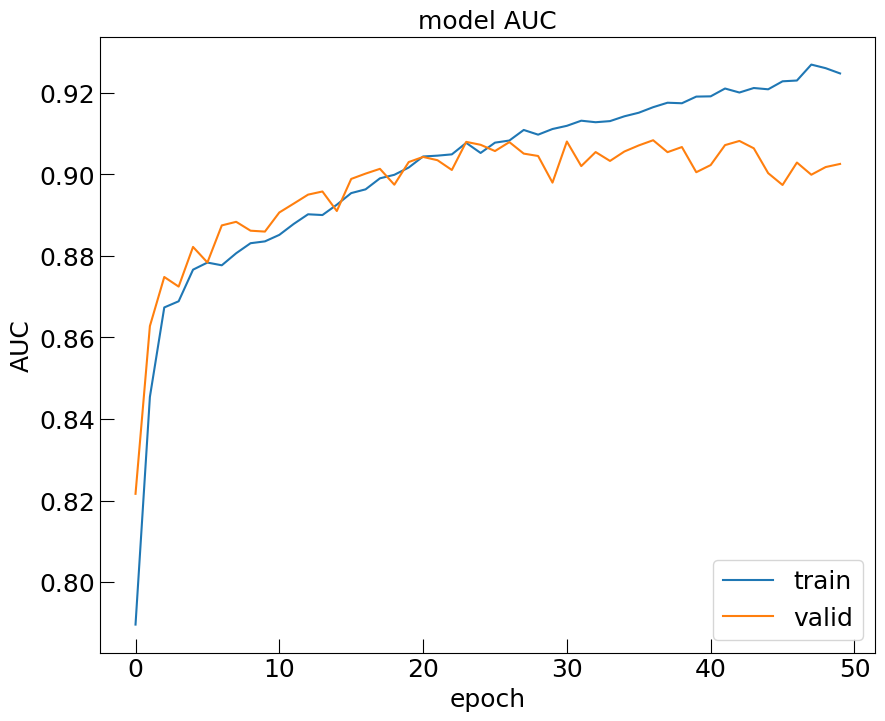

In [13]:
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(history.history['auc'], label='train')
plt.plot(history.history['val_auc'], label='valid')
plt.title('model AUC', fontsize =18)
plt.ylabel('AUC', fontsize =18)
plt.xlabel('epoch', fontsize =18)
plt.legend(loc="lower right",fontsize =18)
ax.tick_params(axis='both', which='major',length=10,direction='in', labelsize=18, zorder=4)

In [14]:
with tf.device('/device:GPU:0'):
    predictions_test_numpy = model.predict(x_test)

3907/3907 [==============================] - 12s 3ms/step


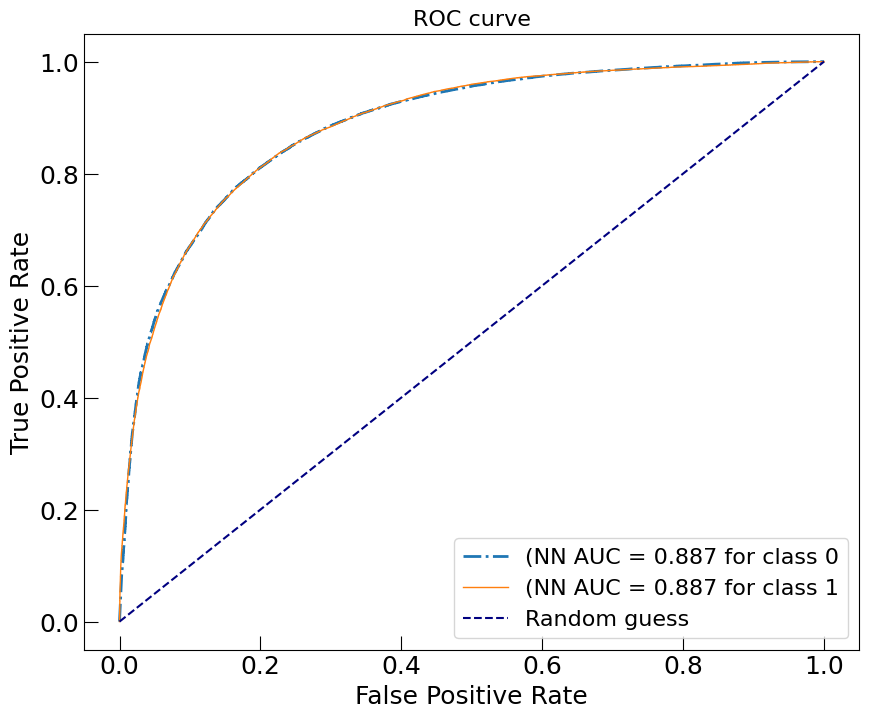

In [15]:
from sklearn.metrics import roc_curve, auc

n_classes = len(np.unique(y_test))
alphas = [0.9, 0.8] * 7
linestyles = ['-.', '-'] * 7
linewidthss = [2, 1] * 7
roc_data = plot_tools.plot_roc_curves(dummy_y_test, predictions_test_numpy, n_classes, linestyles, linewidthss, 'NN')

In [16]:
#The shapley method from the SHAP library will be used to understand the behavior of the model
explainer = shap.KernelExplainer(model, x_train.iloc[:50,:], link="identity", force_cpu=True)
shap_values = explainer.shap_values(x_train.iloc[200:600,:], nsamples=100)


  0%|          | 0/400 [00:00<?, ?it/s]

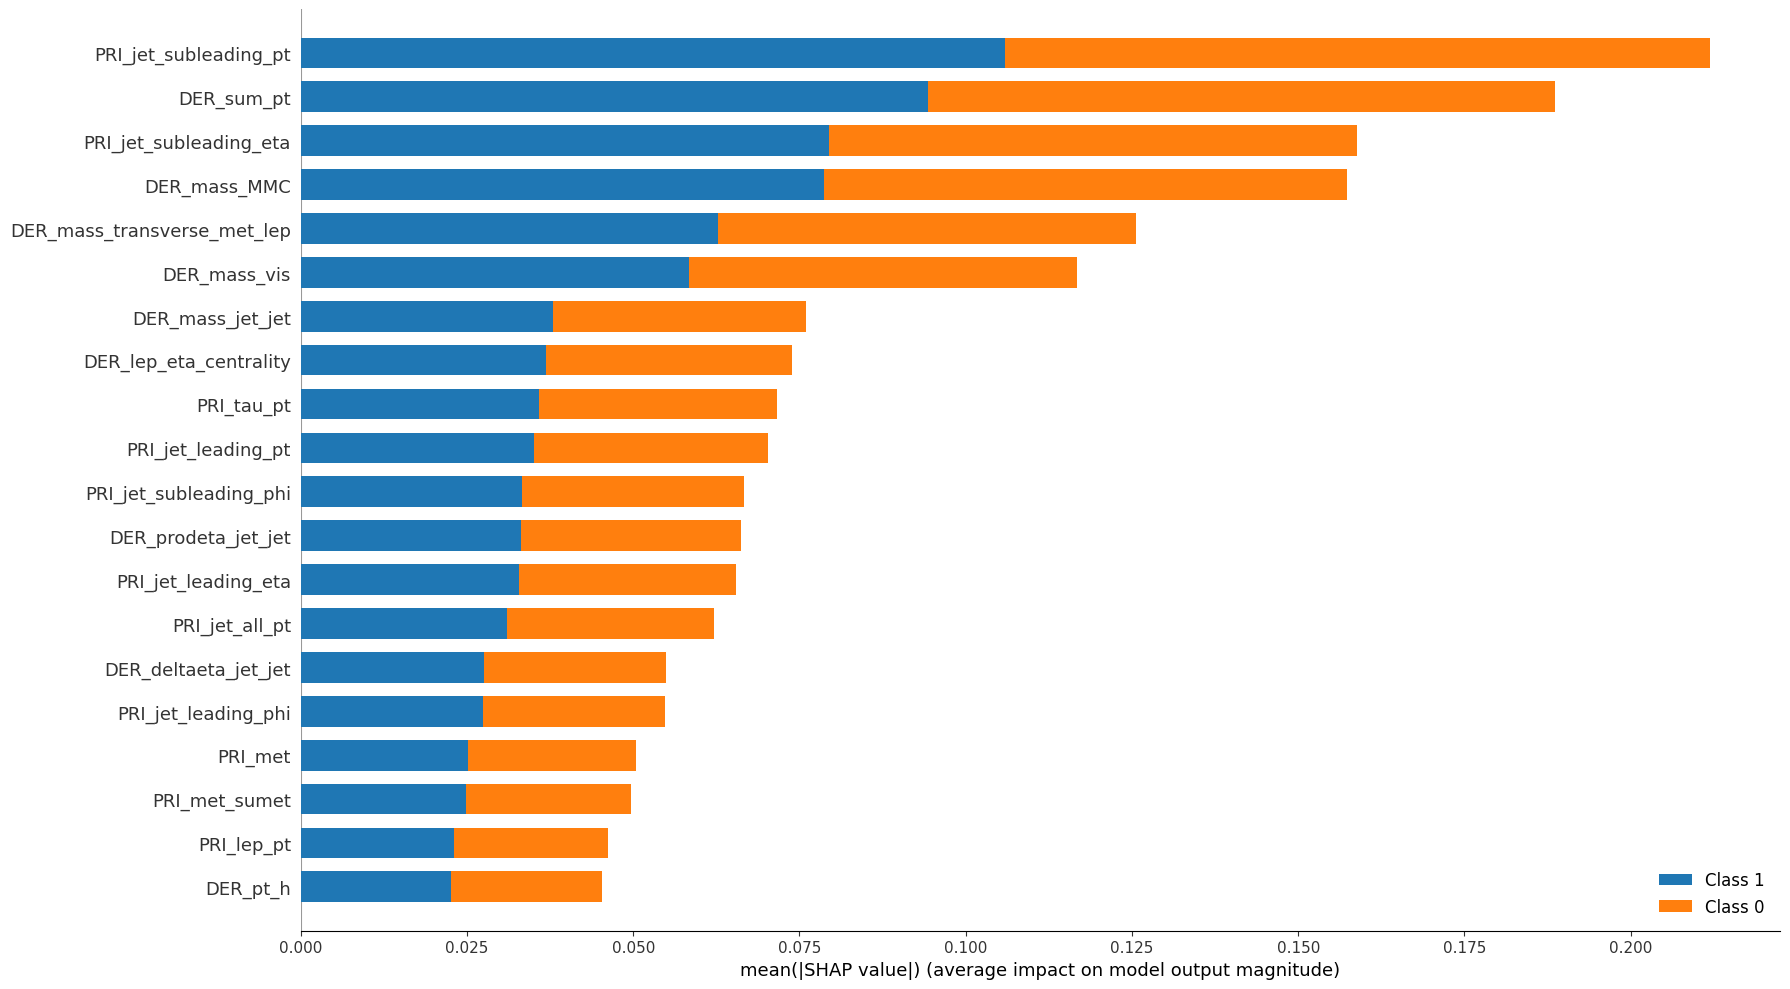

In [17]:
fig, ax= plt.subplots(figsize=(8,6))
shap.summary_plot(shap_values, x_train.iloc[280:330,:], plot_size=[18,10],color=plt.get_cmap("tab10"), show=False)
w, h = plt.gcf().get_size_inches()
plt.gcf().axes[-1].set_aspect('auto')
fig.tight_layout()

The shap summary plot shows that the PRI_jet_leading_pt is the most useful variable for the separation of the two classes

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
import os

path = "/content/drive/MyDrive/HiggsChallenge"
os.mkdir(path)

FileExistsError: ignored

In [ ]:
model.save("/content/drive/MyDrive/HiggsChallenge/deep_model.keras")

## XGBoost
The boosted decision tree algorithm has won many competitions and therefore is an ideal for tabular data [[1]](
https://doi.org/10.48550/arXiv.1603.02754
)

In [18]:
if __name__ == "__main__":
    # Load your dataset and labels here
    BATCHSIZE = 2048

    # Define hyperparameters for XGBoost optimization
    xgboost_hyperparameters = {
        'n_estimators': (100, 1000),
        'alpha': (2, 30),
        'gamma': (0, 1),
        'learning_rate': (0.01, 1),
        'max_depth': (0, 10)
        # Add more XGBoost hyperparameters here as needed
    }

    # Assuming you have your training data (x_train) and labels (y_train_new) loaded
    y_train_new = y_train.replace('s', 1, regex=True)
    y_train_new = y_train_new.replace('b', 0, regex=True)

    # Create an instance of HP_OPT and optimize the XGBoost model
    optimizer = HP_OPT_class_code.HP_OPT(x_train, y_train_new, batch_size=BATCHSIZE, n_trials=10,
                                        xgb_hyp_para=xgboost_hyperparameters,
                                        num_classes=len(np.unique(y_train_new)))

    # Optimize the XGBoost model
    study_xgboost = optimizer.optimize("xgboost")


[I 2023-11-24 15:47:17,783] A new study created in memory with name: no-name-0981467b-8c0b-4a73-a6cb-d07edb1afa82
[I 2023-11-24 15:47:30,089] Trial 0 finished with value: 0.8730768765060951 and parameters: {'n_estimators': 900, 'alpha': 4, 'gamma': 0.34396321364701243, 'learning_rate': 0.019189615590813572, 'max_depth': 1}. Best is trial 0 with value: 0.8730768765060951.
[I 2023-11-24 15:47:36,035] Trial 1 finished with value: 0.9048485025301897 and parameters: {'n_estimators': 190, 'alpha': 22, 'gamma': 0.7454547793430142, 'learning_rate': 0.04630716963895608, 'max_depth': 5}. Best is trial 1 with value: 0.9048485025301897.
[I 2023-11-24 15:47:40,491] Trial 2 finished with value: 0.9035286049469339 and parameters: {'n_estimators': 200, 'alpha': 22, 'gamma': 0.06593882258488748, 'learning_rate': 0.9336684566155928, 'max_depth': 3}. Best is trial 1 with value: 0.9048485025301897.
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worke

XGBoost Best Trial:


In [19]:
figure = plot_optimization_history(study_xgboost)
newnames = {'Objective Value':'TPE Objective', 'Best Value': 'TPE Best'} # From the other post
figure.update_traces(marker=dict(color="RoyalBlue",opacity=0.5,symbol=100), line=dict(dash='dash'))
figure.update_layout(
    title={
        'text': "",
        'y':0.85,
        'x':0.5,
        'yanchor': 'top'},
    legend=dict(
    yanchor="top",
    y=0.3,
    xanchor="left",
    x=0.6
),yaxis_range=[0.9,1.001],
    xaxis_title={'text':"Trial",'standoff':0.01,},
    yaxis_title={'text':"mean AUC (test)",'standoff':0.01,},
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)
figure.update_traces(marker=dict(color="Blue",size=10, symbol=200), line=dict(dash='dot', width=4))



In [20]:
param= {'alpha': study_xgboost.best_params["alpha"], 'gamma': study_xgboost.best_params["gamma"],
        'learning_rate': study_xgboost.best_params["learning_rate"],
        'max_depth': int(round(study_xgboost.best_params["max_depth"],0)),
        'n_estimators': int(round(study_xgboost.best_params["n_estimators"],0)), 'num_class':2,'objective':'multi:softmax',
        'subsample': 0.8,'eval_metric': 'auc','tree_method':'hist', 'device':'cuda'}

import xgboost as xgb
#Fit/train on training data
xgb_clf = xgb.XGBClassifier(**param)
xgb_clf.fit(x_train,y_train_new)

XGBClassifier(alpha=16, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.11042354959128875, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0223651004560007,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=540, n_jobs=None, num_class=2, ...)

In [21]:
predictions=xgb_clf.predict_proba(x_test)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[15:53:33] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.




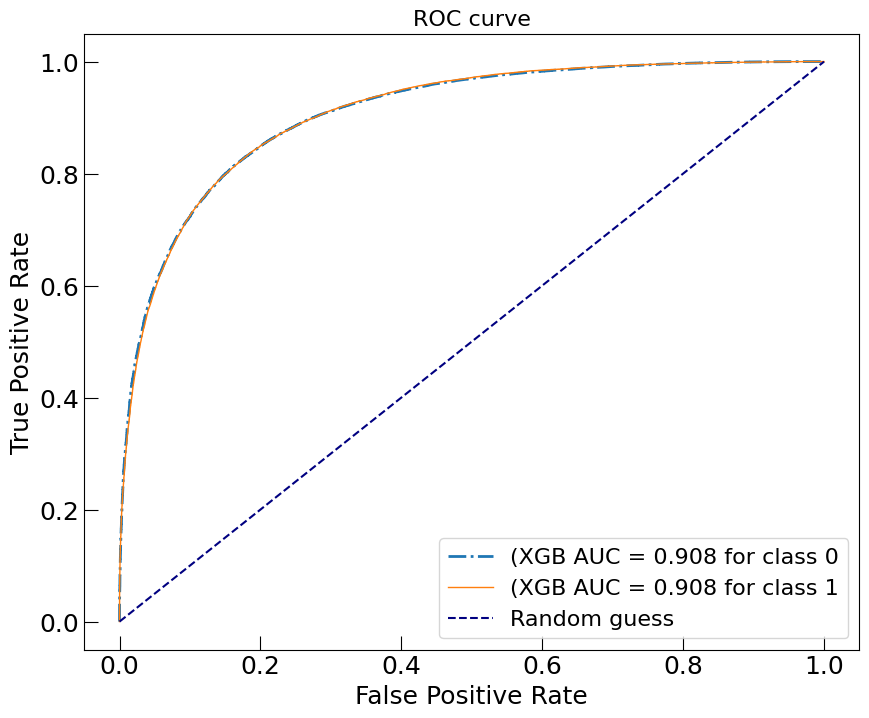

In [22]:
roc_data_xgb = plot_tools.plot_roc_curves(dummy_y_test, predictions, n_classes, linestyles, linewidthss, 'XGB')

In [23]:
x_train_small = x_train.sample(n=100)
import time

start = time.time()
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(x_train_small)
end = time.time()
print(end - start)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[15:53:33] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



1.3787891864776611


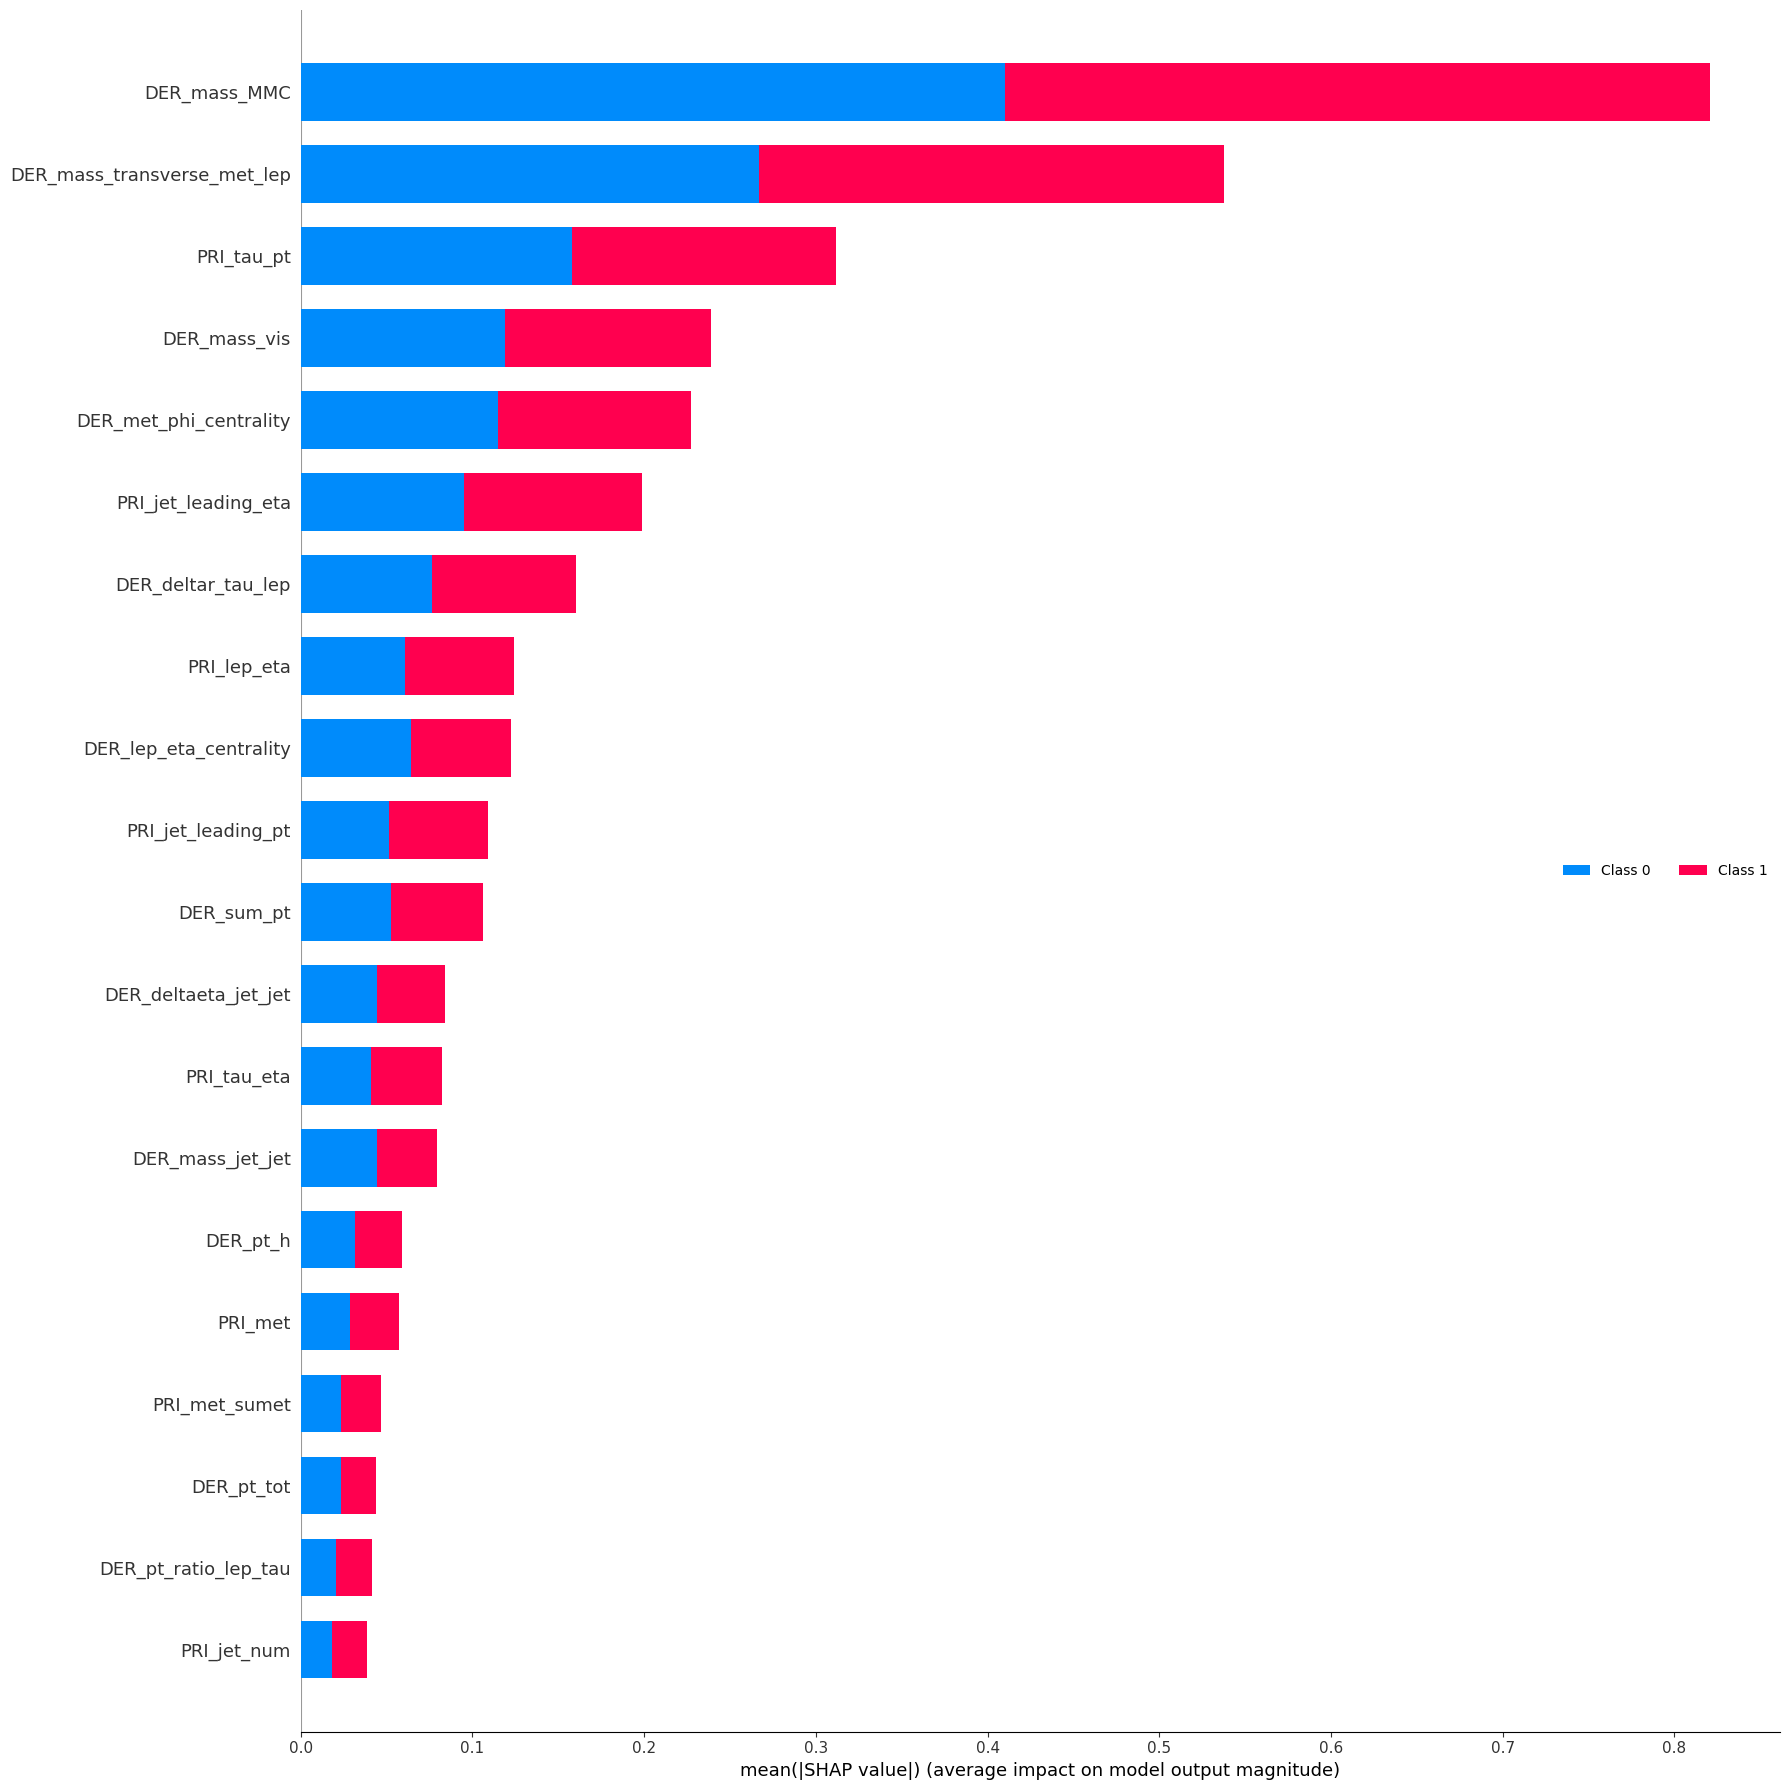

In [24]:
from matplotlib.colors import ListedColormap
fig, ax= plt.subplots(figsize=(18,18))
shap.summary_plot(shap_values, x_train_small,plot_size=[18,18], show=False)

w, h = plt.gcf().get_size_inches()
plt.gcf().axes[-1].set_aspect('auto')
plt.legend(loc='center right',ncol=2, frameon=False, fontsize=10)
fig.tight_layout()

In [ ]:
xgb_clf.save_model('/content/drive/MyDrive/HiggsChallenge/xgb.model')

## Comparison between NN and XGB

Text(0, 0.5, 'True Positive Rate')

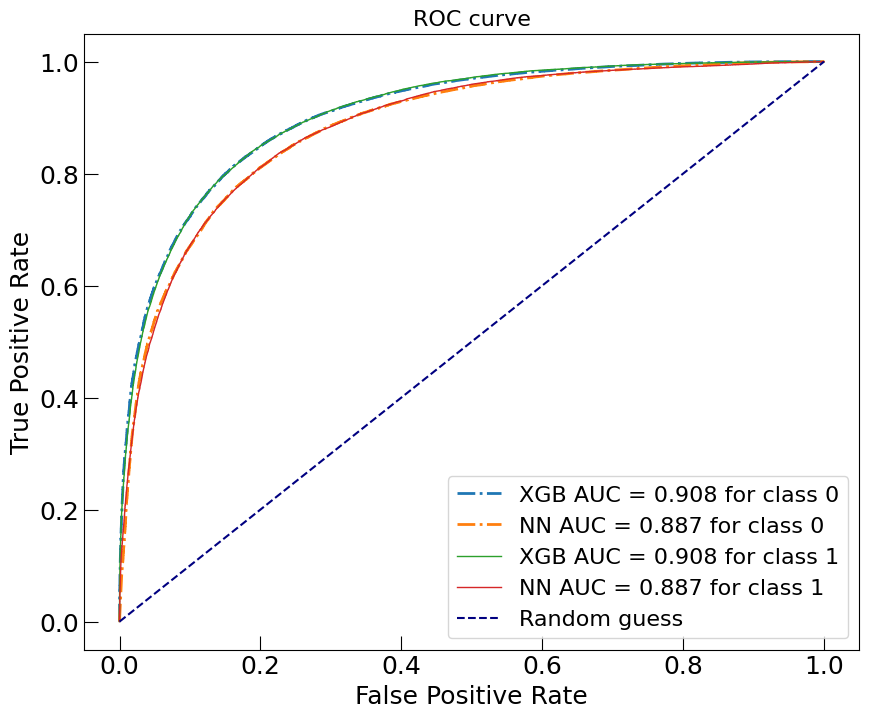

In [25]:
fig, ax =plt.subplots(figsize=(10,8))
for i in range(n_classes):
    plt.plot(roc_data_xgb[i]['fpr'],roc_data_xgb[i]['tpr'],linestyle=linestyles[i],linewidth=linewidthss[i],label=f"XGB AUC = {roc_data_xgb[i]['roc_auc']:0.3f} for class {i}")
    plt.plot(roc_data[i]['fpr'], roc_data[i]['tpr'],linestyle=linestyles[i],linewidth=linewidthss[i],label=f"NN AUC = {roc_data[i]['roc_auc']:0.3f} for class {i}")

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random guess')
plt.title("ROC curve", fontsize=16)
plt.legend(loc='lower right',fontsize=16)
ax.tick_params(axis='both', which='major',length=10,direction='in', labelsize=18, zorder=4)
plt.xlabel("False Positive Rate",fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)

In [26]:
x_unseen = df_test[new_cuts].copy()

with tf.device('/device:GPU:0'):
    predictions_test_numpy = model.predict(x_unseen)

17188/17188 [==============================] - 49s 3ms/step


## CNN

In [27]:
if __name__ == "__main__":
    BATCHSIZE = 2048
    cnn_hyperparameters = {
        'filters': [32, 64],
        'kernel_size': [3, 5],
        'strides': [1, 2],
        'n_conv_layers_min': 0,
        'n_conv_layers_max': 3,
        'dropout_min': 0.0,
        'dropout_max': 0.5,
        'n_layers_min': 2,
        'n_layers_max': 22,
        'n_units_min': 1000,
        'n_units_max': 2500,
        'learning_rate_min': 1e-5,
        'learning_rate_max': 1e-1
    }
    y_train_new = y_train.replace('s', 1, regex=True)
    y_train_new = y_train_new.replace('b', 0, regex=True)
    optimizer = HP_OPT_class_code.HP_OPT(x_train, y_train_new, batch_size=BATCHSIZE, n_trials=10,
                                        cnn_hyp_par=cnn_hyperparameters,
                                        num_classes=len(np.unique(y_train_new)))
    study_cnn = optimizer.optimize("cnn")

[I 2023-11-24 15:54:37,427] A new study created in memory with name: no-name-51d0c41c-e53a-45db-ae88-bdaf2b987284
[I 2023-11-24 15:55:22,878] Trial 0 finished with value: 0.6572800278663635 and parameters: {'filters': 64, 'kernel_size': 3, 'strides': 1, 'n_conv_layers': 2, 'conv_dropout_rate_l0': 0.09284770438588408, 'n_layers': 5, 'n_units_l0': 2250, 'dropout_rate_l0': 0.23149030635750073, 'n_units_l1': 1207, 'dropout_rate_l1': 0.2906198669930484, 'n_units_l2': 1000, 'dropout_rate_l2': 0.4211565737181762, 'n_units_l3': 2295, 'dropout_rate_l3': 0.46670935356853105, 'n_units_l4': 1522, 'dropout_rate_l4': 0.19679358273689662, 'learning_rate': 0.03081883233786751}. Best is trial 0 with value: 0.6572800278663635.


Trial 0, Score: 0.6572800278663635
Parameters: {'filters': 64, 'kernel_size': 3, 'strides': 1, 'n_conv_layers': 2, 'conv_dropout_rate_l0': 0.09284770438588408, 'n_layers': 5, 'n_units_l0': 2250, 'dropout_rate_l0': 0.23149030635750073, 'n_units_l1': 1207, 'dropout_rate_l1': 0.2906198669930484, 'n_units_l2': 1000, 'dropout_rate_l2': 0.4211565737181762, 'n_units_l3': 2295, 'dropout_rate_l3': 0.46670935356853105, 'n_units_l4': 1522, 'dropout_rate_l4': 0.19679358273689662, 'learning_rate': 0.03081883233786751}


[I 2023-11-24 15:56:26,383] Trial 1 finished with value: 0.6594399809837341 and parameters: {'filters': 32, 'kernel_size': 5, 'strides': 1, 'n_conv_layers': 1, 'n_layers': 9, 'n_units_l0': 1064, 'dropout_rate_l0': 0.25639192521477727, 'n_units_l1': 1738, 'dropout_rate_l1': 0.4559247576823707, 'n_units_l2': 1187, 'dropout_rate_l2': 0.35494570869927033, 'n_units_l3': 1880, 'dropout_rate_l3': 0.0485195980369344, 'n_units_l4': 2408, 'dropout_rate_l4': 0.18457468267809757, 'n_units_l5': 2419, 'dropout_rate_l5': 0.4264548038617367, 'n_units_l6': 2329, 'dropout_rate_l6': 0.40359853790123673, 'n_units_l7': 2092, 'dropout_rate_l7': 0.4770561387751481, 'n_units_l8': 1193, 'dropout_rate_l8': 0.0032685263263809716, 'learning_rate': 0.00016498189337640982}. Best is trial 1 with value: 0.6594399809837341.


Trial 1, Score: 0.6594399809837341
Parameters: {'filters': 32, 'kernel_size': 5, 'strides': 1, 'n_conv_layers': 1, 'n_layers': 9, 'n_units_l0': 1064, 'dropout_rate_l0': 0.25639192521477727, 'n_units_l1': 1738, 'dropout_rate_l1': 0.4559247576823707, 'n_units_l2': 1187, 'dropout_rate_l2': 0.35494570869927033, 'n_units_l3': 1880, 'dropout_rate_l3': 0.0485195980369344, 'n_units_l4': 2408, 'dropout_rate_l4': 0.18457468267809757, 'n_units_l5': 2419, 'dropout_rate_l5': 0.4264548038617367, 'n_units_l6': 2329, 'dropout_rate_l6': 0.40359853790123673, 'n_units_l7': 2092, 'dropout_rate_l7': 0.4770561387751481, 'n_units_l8': 1193, 'dropout_rate_l8': 0.0032685263263809716, 'learning_rate': 0.00016498189337640982}


[I 2023-11-24 15:57:58,054] Trial 2 finished with value: 0.6573200225830078 and parameters: {'filters': 32, 'kernel_size': 3, 'strides': 2, 'n_conv_layers': 2, 'conv_dropout_rate_l0': 0.49498701334915246, 'n_layers': 21, 'n_units_l0': 1357, 'dropout_rate_l0': 0.380104570681126, 'n_units_l1': 1451, 'dropout_rate_l1': 0.3573234927674558, 'n_units_l2': 2208, 'dropout_rate_l2': 0.3996898284829815, 'n_units_l3': 1342, 'dropout_rate_l3': 0.26971200342539176, 'n_units_l4': 1322, 'dropout_rate_l4': 0.20501738629218247, 'n_units_l5': 1143, 'dropout_rate_l5': 0.09863282959315889, 'n_units_l6': 1170, 'dropout_rate_l6': 0.2070780629311868, 'n_units_l7': 1167, 'dropout_rate_l7': 0.35566360386708906, 'n_units_l8': 1648, 'dropout_rate_l8': 0.26728323654193104, 'n_units_l9': 1055, 'dropout_rate_l9': 0.14305068821275646, 'n_units_l10': 2053, 'dropout_rate_l10': 0.34182574867067606, 'n_units_l11': 1777, 'dropout_rate_l11': 0.09457226823169956, 'n_units_l12': 1257, 'dropout_rate_l12': 0.3999029027180665,

Trial 2, Score: 0.6573200225830078
Parameters: {'filters': 32, 'kernel_size': 3, 'strides': 2, 'n_conv_layers': 2, 'conv_dropout_rate_l0': 0.49498701334915246, 'n_layers': 21, 'n_units_l0': 1357, 'dropout_rate_l0': 0.380104570681126, 'n_units_l1': 1451, 'dropout_rate_l1': 0.3573234927674558, 'n_units_l2': 2208, 'dropout_rate_l2': 0.3996898284829815, 'n_units_l3': 1342, 'dropout_rate_l3': 0.26971200342539176, 'n_units_l4': 1322, 'dropout_rate_l4': 0.20501738629218247, 'n_units_l5': 1143, 'dropout_rate_l5': 0.09863282959315889, 'n_units_l6': 1170, 'dropout_rate_l6': 0.2070780629311868, 'n_units_l7': 1167, 'dropout_rate_l7': 0.35566360386708906, 'n_units_l8': 1648, 'dropout_rate_l8': 0.26728323654193104, 'n_units_l9': 1055, 'dropout_rate_l9': 0.14305068821275646, 'n_units_l10': 2053, 'dropout_rate_l10': 0.34182574867067606, 'n_units_l11': 1777, 'dropout_rate_l11': 0.09457226823169956, 'n_units_l12': 1257, 'dropout_rate_l12': 0.3999029027180665, 'n_units_l13': 2156, 'dropout_rate_l13': 0.0

[I 2023-11-24 16:00:39,223] Trial 3 finished with value: 0.6583200097084045 and parameters: {'filters': 64, 'kernel_size': 3, 'strides': 2, 'n_conv_layers': 2, 'conv_dropout_rate_l0': 0.369615349552925, 'n_layers': 22, 'n_units_l0': 2193, 'dropout_rate_l0': 0.36616386557240954, 'n_units_l1': 1451, 'dropout_rate_l1': 0.3549604740780364, 'n_units_l2': 2429, 'dropout_rate_l2': 0.40139615511504534, 'n_units_l3': 1643, 'dropout_rate_l3': 0.40277037721517084, 'n_units_l4': 1333, 'dropout_rate_l4': 0.4867586455510039, 'n_units_l5': 1090, 'dropout_rate_l5': 0.21087116391251354, 'n_units_l6': 1006, 'dropout_rate_l6': 0.025190687278784818, 'n_units_l7': 1534, 'dropout_rate_l7': 0.172435542486562, 'n_units_l8': 1584, 'dropout_rate_l8': 0.46101953539642854, 'n_units_l9': 1449, 'dropout_rate_l9': 0.44331414103575995, 'n_units_l10': 1324, 'dropout_rate_l10': 0.38011535977017497, 'n_units_l11': 2189, 'dropout_rate_l11': 0.05581893047910658, 'n_units_l12': 1042, 'dropout_rate_l12': 0.2076530243135331,

Trial 3, Score: 0.6583200097084045
Parameters: {'filters': 64, 'kernel_size': 3, 'strides': 2, 'n_conv_layers': 2, 'conv_dropout_rate_l0': 0.369615349552925, 'n_layers': 22, 'n_units_l0': 2193, 'dropout_rate_l0': 0.36616386557240954, 'n_units_l1': 1451, 'dropout_rate_l1': 0.3549604740780364, 'n_units_l2': 2429, 'dropout_rate_l2': 0.40139615511504534, 'n_units_l3': 1643, 'dropout_rate_l3': 0.40277037721517084, 'n_units_l4': 1333, 'dropout_rate_l4': 0.4867586455510039, 'n_units_l5': 1090, 'dropout_rate_l5': 0.21087116391251354, 'n_units_l6': 1006, 'dropout_rate_l6': 0.025190687278784818, 'n_units_l7': 1534, 'dropout_rate_l7': 0.172435542486562, 'n_units_l8': 1584, 'dropout_rate_l8': 0.46101953539642854, 'n_units_l9': 1449, 'dropout_rate_l9': 0.44331414103575995, 'n_units_l10': 1324, 'dropout_rate_l10': 0.38011535977017497, 'n_units_l11': 2189, 'dropout_rate_l11': 0.05581893047910658, 'n_units_l12': 1042, 'dropout_rate_l12': 0.2076530243135331, 'n_units_l13': 1253, 'dropout_rate_l13': 0.2

[I 2023-11-24 16:02:15,062] Trial 4 finished with value: 0.660319983959198 and parameters: {'filters': 32, 'kernel_size': 3, 'strides': 2, 'n_conv_layers': 1, 'n_layers': 14, 'n_units_l0': 1196, 'dropout_rate_l0': 0.13994298219063894, 'n_units_l1': 1599, 'dropout_rate_l1': 0.11026769455862745, 'n_units_l2': 1383, 'dropout_rate_l2': 0.4583793917753157, 'n_units_l3': 1168, 'dropout_rate_l3': 0.24221004195048046, 'n_units_l4': 1598, 'dropout_rate_l4': 0.10806220797584876, 'n_units_l5': 1244, 'dropout_rate_l5': 0.20339770159290727, 'n_units_l6': 1003, 'dropout_rate_l6': 0.4519839571251029, 'n_units_l7': 2263, 'dropout_rate_l7': 0.3592675999430374, 'n_units_l8': 1225, 'dropout_rate_l8': 0.2901575804513455, 'n_units_l9': 1256, 'dropout_rate_l9': 0.22122616072053902, 'n_units_l10': 1014, 'dropout_rate_l10': 0.20196346000528853, 'n_units_l11': 1783, 'dropout_rate_l11': 0.47818969667045186, 'n_units_l12': 2470, 'dropout_rate_l12': 0.43502788872567544, 'n_units_l13': 1730, 'dropout_rate_l13': 0.

Trial 4, Score: 0.660319983959198
Parameters: {'filters': 32, 'kernel_size': 3, 'strides': 2, 'n_conv_layers': 1, 'n_layers': 14, 'n_units_l0': 1196, 'dropout_rate_l0': 0.13994298219063894, 'n_units_l1': 1599, 'dropout_rate_l1': 0.11026769455862745, 'n_units_l2': 1383, 'dropout_rate_l2': 0.4583793917753157, 'n_units_l3': 1168, 'dropout_rate_l3': 0.24221004195048046, 'n_units_l4': 1598, 'dropout_rate_l4': 0.10806220797584876, 'n_units_l5': 1244, 'dropout_rate_l5': 0.20339770159290727, 'n_units_l6': 1003, 'dropout_rate_l6': 0.4519839571251029, 'n_units_l7': 2263, 'dropout_rate_l7': 0.3592675999430374, 'n_units_l8': 1225, 'dropout_rate_l8': 0.2901575804513455, 'n_units_l9': 1256, 'dropout_rate_l9': 0.22122616072053902, 'n_units_l10': 1014, 'dropout_rate_l10': 0.20196346000528853, 'n_units_l11': 1783, 'dropout_rate_l11': 0.47818969667045186, 'n_units_l12': 2470, 'dropout_rate_l12': 0.43502788872567544, 'n_units_l13': 1730, 'dropout_rate_l13': 0.26396765461021165, 'learning_rate': 1.0016018

[I 2023-11-24 16:04:53,062] Trial 5 finished with value: 0.6582000255584717 and parameters: {'filters': 32, 'kernel_size': 5, 'strides': 2, 'n_conv_layers': 0, 'n_layers': 18, 'n_units_l0': 1391, 'dropout_rate_l0': 0.26017679037193026, 'n_units_l1': 2047, 'dropout_rate_l1': 0.09578618140802525, 'n_units_l2': 2007, 'dropout_rate_l2': 0.02499687495670605, 'n_units_l3': 1212, 'dropout_rate_l3': 0.024065304142815214, 'n_units_l4': 1102, 'dropout_rate_l4': 0.44602948616786275, 'n_units_l5': 2230, 'dropout_rate_l5': 0.49481249457754084, 'n_units_l6': 2062, 'dropout_rate_l6': 0.028241344466525597, 'n_units_l7': 1270, 'dropout_rate_l7': 0.4785860339467488, 'n_units_l8': 2053, 'dropout_rate_l8': 0.175358303251882, 'n_units_l9': 1492, 'dropout_rate_l9': 0.029708589061176405, 'n_units_l10': 1910, 'dropout_rate_l10': 0.3239329955431881, 'n_units_l11': 1657, 'dropout_rate_l11': 0.34057913402035667, 'n_units_l12': 1026, 'dropout_rate_l12': 0.3414422278631549, 'n_units_l13': 1560, 'dropout_rate_l13':

Trial 5, Score: 0.6582000255584717
Parameters: {'filters': 32, 'kernel_size': 5, 'strides': 2, 'n_conv_layers': 0, 'n_layers': 18, 'n_units_l0': 1391, 'dropout_rate_l0': 0.26017679037193026, 'n_units_l1': 2047, 'dropout_rate_l1': 0.09578618140802525, 'n_units_l2': 2007, 'dropout_rate_l2': 0.02499687495670605, 'n_units_l3': 1212, 'dropout_rate_l3': 0.024065304142815214, 'n_units_l4': 1102, 'dropout_rate_l4': 0.44602948616786275, 'n_units_l5': 2230, 'dropout_rate_l5': 0.49481249457754084, 'n_units_l6': 2062, 'dropout_rate_l6': 0.028241344466525597, 'n_units_l7': 1270, 'dropout_rate_l7': 0.4785860339467488, 'n_units_l8': 2053, 'dropout_rate_l8': 0.175358303251882, 'n_units_l9': 1492, 'dropout_rate_l9': 0.029708589061176405, 'n_units_l10': 1910, 'dropout_rate_l10': 0.3239329955431881, 'n_units_l11': 1657, 'dropout_rate_l11': 0.34057913402035667, 'n_units_l12': 1026, 'dropout_rate_l12': 0.3414422278631549, 'n_units_l13': 1560, 'dropout_rate_l13': 0.08161932299943914, 'n_units_l14': 1636, 'd

[I 2023-11-24 16:06:11,512] Trial 6 finished with value: 0.6573200225830078 and parameters: {'filters': 32, 'kernel_size': 5, 'strides': 2, 'n_conv_layers': 2, 'conv_dropout_rate_l0': 0.31113860225339063, 'n_layers': 11, 'n_units_l0': 1076, 'dropout_rate_l0': 0.0639627094545342, 'n_units_l1': 1249, 'dropout_rate_l1': 0.10782580385694679, 'n_units_l2': 2243, 'dropout_rate_l2': 0.38637498729743963, 'n_units_l3': 2422, 'dropout_rate_l3': 0.3935350279297887, 'n_units_l4': 1367, 'dropout_rate_l4': 0.24307190939350537, 'n_units_l5': 1801, 'dropout_rate_l5': 0.15312197723200394, 'n_units_l6': 1149, 'dropout_rate_l6': 0.25808452538815174, 'n_units_l7': 1133, 'dropout_rate_l7': 0.20568987135434857, 'n_units_l8': 1068, 'dropout_rate_l8': 0.016473473764761493, 'n_units_l9': 1685, 'dropout_rate_l9': 0.2867928060003643, 'n_units_l10': 1560, 'dropout_rate_l10': 0.3285484752776992, 'learning_rate': 0.008161300724221327}. Best is trial 4 with value: 0.660319983959198.


Trial 6, Score: 0.6573200225830078
Parameters: {'filters': 32, 'kernel_size': 5, 'strides': 2, 'n_conv_layers': 2, 'conv_dropout_rate_l0': 0.31113860225339063, 'n_layers': 11, 'n_units_l0': 1076, 'dropout_rate_l0': 0.0639627094545342, 'n_units_l1': 1249, 'dropout_rate_l1': 0.10782580385694679, 'n_units_l2': 2243, 'dropout_rate_l2': 0.38637498729743963, 'n_units_l3': 2422, 'dropout_rate_l3': 0.3935350279297887, 'n_units_l4': 1367, 'dropout_rate_l4': 0.24307190939350537, 'n_units_l5': 1801, 'dropout_rate_l5': 0.15312197723200394, 'n_units_l6': 1149, 'dropout_rate_l6': 0.25808452538815174, 'n_units_l7': 1133, 'dropout_rate_l7': 0.20568987135434857, 'n_units_l8': 1068, 'dropout_rate_l8': 0.016473473764761493, 'n_units_l9': 1685, 'dropout_rate_l9': 0.2867928060003643, 'n_units_l10': 1560, 'dropout_rate_l10': 0.3285484752776992, 'learning_rate': 0.008161300724221327}


[I 2023-11-24 16:07:11,203] Trial 7 finished with value: 0.6573200225830078 and parameters: {'filters': 32, 'kernel_size': 5, 'strides': 2, 'n_conv_layers': 1, 'n_layers': 8, 'n_units_l0': 1639, 'dropout_rate_l0': 0.3993173365503678, 'n_units_l1': 1383, 'dropout_rate_l1': 0.061949859135271845, 'n_units_l2': 1909, 'dropout_rate_l2': 0.018387096524592805, 'n_units_l3': 1314, 'dropout_rate_l3': 0.27937733507856277, 'n_units_l4': 2387, 'dropout_rate_l4': 0.1784022005664916, 'n_units_l5': 2256, 'dropout_rate_l5': 0.4678455879930279, 'n_units_l6': 1259, 'dropout_rate_l6': 0.3464310376169588, 'n_units_l7': 2245, 'dropout_rate_l7': 0.40457111725990735, 'learning_rate': 0.0003899549347714724}. Best is trial 4 with value: 0.660319983959198.


Trial 7, Score: 0.6573200225830078
Parameters: {'filters': 32, 'kernel_size': 5, 'strides': 2, 'n_conv_layers': 1, 'n_layers': 8, 'n_units_l0': 1639, 'dropout_rate_l0': 0.3993173365503678, 'n_units_l1': 1383, 'dropout_rate_l1': 0.061949859135271845, 'n_units_l2': 1909, 'dropout_rate_l2': 0.018387096524592805, 'n_units_l3': 1314, 'dropout_rate_l3': 0.27937733507856277, 'n_units_l4': 2387, 'dropout_rate_l4': 0.1784022005664916, 'n_units_l5': 2256, 'dropout_rate_l5': 0.4678455879930279, 'n_units_l6': 1259, 'dropout_rate_l6': 0.3464310376169588, 'n_units_l7': 2245, 'dropout_rate_l7': 0.40457111725990735, 'learning_rate': 0.0003899549347714724}


[I 2023-11-24 16:08:36,781] Trial 8 finished with value: 0.6611199975013733 and parameters: {'filters': 32, 'kernel_size': 5, 'strides': 1, 'n_conv_layers': 0, 'n_layers': 10, 'n_units_l0': 1338, 'dropout_rate_l0': 0.28165010000175916, 'n_units_l1': 1892, 'dropout_rate_l1': 0.20196348239131223, 'n_units_l2': 2227, 'dropout_rate_l2': 0.21408769468856215, 'n_units_l3': 1396, 'dropout_rate_l3': 0.2309715623296592, 'n_units_l4': 1441, 'dropout_rate_l4': 0.009061816874605777, 'n_units_l5': 2348, 'dropout_rate_l5': 0.20304061684926572, 'n_units_l6': 1820, 'dropout_rate_l6': 0.10699323031497532, 'n_units_l7': 2117, 'dropout_rate_l7': 0.43709341829204384, 'n_units_l8': 1257, 'dropout_rate_l8': 0.4444544733187073, 'n_units_l9': 1124, 'dropout_rate_l9': 0.24416821561904328, 'learning_rate': 2.2276430451526645e-05}. Best is trial 8 with value: 0.6611199975013733.


Trial 8, Score: 0.6611199975013733
Parameters: {'filters': 32, 'kernel_size': 5, 'strides': 1, 'n_conv_layers': 0, 'n_layers': 10, 'n_units_l0': 1338, 'dropout_rate_l0': 0.28165010000175916, 'n_units_l1': 1892, 'dropout_rate_l1': 0.20196348239131223, 'n_units_l2': 2227, 'dropout_rate_l2': 0.21408769468856215, 'n_units_l3': 1396, 'dropout_rate_l3': 0.2309715623296592, 'n_units_l4': 1441, 'dropout_rate_l4': 0.009061816874605777, 'n_units_l5': 2348, 'dropout_rate_l5': 0.20304061684926572, 'n_units_l6': 1820, 'dropout_rate_l6': 0.10699323031497532, 'n_units_l7': 2117, 'dropout_rate_l7': 0.43709341829204384, 'n_units_l8': 1257, 'dropout_rate_l8': 0.4444544733187073, 'n_units_l9': 1124, 'dropout_rate_l9': 0.24416821561904328, 'learning_rate': 2.2276430451526645e-05}


[I 2023-11-24 16:09:24,524] Trial 9 finished with value: 0.6613600254058838 and parameters: {'filters': 64, 'kernel_size': 5, 'strides': 1, 'n_conv_layers': 0, 'n_layers': 6, 'n_units_l0': 1811, 'dropout_rate_l0': 0.1999056800842529, 'n_units_l1': 1551, 'dropout_rate_l1': 0.12406191908742953, 'n_units_l2': 1723, 'dropout_rate_l2': 0.4753391559367516, 'n_units_l3': 1155, 'dropout_rate_l3': 0.1065993260286981, 'n_units_l4': 1023, 'dropout_rate_l4': 0.49907282529150865, 'n_units_l5': 1368, 'dropout_rate_l5': 0.2855996192743144, 'learning_rate': 0.0001408997887303967}. Best is trial 9 with value: 0.6613600254058838.


Trial 9, Score: 0.6613600254058838
Parameters: {'filters': 64, 'kernel_size': 5, 'strides': 1, 'n_conv_layers': 0, 'n_layers': 6, 'n_units_l0': 1811, 'dropout_rate_l0': 0.1999056800842529, 'n_units_l1': 1551, 'dropout_rate_l1': 0.12406191908742953, 'n_units_l2': 1723, 'dropout_rate_l2': 0.4753391559367516, 'n_units_l3': 1155, 'dropout_rate_l3': 0.1065993260286981, 'n_units_l4': 1023, 'dropout_rate_l4': 0.49907282529150865, 'n_units_l5': 1368, 'dropout_rate_l5': 0.2855996192743144, 'learning_rate': 0.0001408997887303967}
CNN Best Trial:


In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

BATCHSIZE = 1024
CLASSES = len(np.unique(y_train))
EPOCHS = 10

# Reshape data to simulate an image structure
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], 1)
input_shape = (X_train.shape[1], 1)

y_train_new = y_train.replace('s', 1, regex=True)
y_train_new = y_train_new.replace('b', 0, regex=True)

In [29]:
best_cnn_params = study_cnn.best_params
# Create a CNN model with the best hyperparameters
model_cnn = tf.keras.Sequential()
model_cnn.add(
    Conv1D(
        filters=best_cnn_params["filters"],
        kernel_size=best_cnn_params["kernel_size"],
        strides=best_cnn_params["strides"],
        activation="linear",
        input_shape = input_shape
    )
)
# Add the rest of the CNN layers using best_cnn_params
for i in range(best_cnn_params["n_conv_layers"] - 1):
    model_cnn.add(
        Conv1D(
            filters=best_cnn_params["filters"],
            kernel_size=best_cnn_params["kernel_size"],
            strides=best_cnn_params["strides"],
            activation="linear",
        )
    )
    model_cnn.add(Dropout(best_cnn_params[f"conv_dropout_rate_l{i}"]))

model_cnn.add(Flatten())

for i in range(best_cnn_params["n_layers"]):
    num_hidden = best_cnn_params[f"n_units_l{i}"]
    model_cnn.add(Dense(num_hidden, activation="relu", activity_regularizer=l1(0.001)))
    dropout_rate = best_cnn_params[f"dropout_rate_l{i}"]
    model_cnn.add(Dropout(dropout_rate))
    model_cnn.add(BatchNormalization())

model_cnn.add(Dense(n_classes, activation="softmax"))

learning_rate = best_cnn_params["learning_rate"]
model_cnn.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(learning_rate=learning_rate),
    metrics=["accuracy"],
)

# Train the CNN model with your training data
early_stop = EarlyStopping(monitor='val_loss', patience=3)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

model_cnn.fit(
    X_train,
    y_train_new,
    shuffle=True,
    batch_size=BATCHSIZE,
    epochs=50,  # You can adjust the number of epochs as needed
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/50
98/98 [==============================] - ETA: 0s - loss: 3.0035 - accuracy: 0.7065

98/98 [==============================] - 10s 37ms/step - loss: 3.0035 - accuracy: 0.7065
Epoch 2/50
97/98 [============================>.] - ETA: 0s - loss: 2.0006 - accuracy: 0.7794

98/98 [==============================] - 3s 35ms/step - loss: 1.9996 - accuracy: 0.7794
Epoch 3/50
97/98 [============================>.] - ETA: 0s - loss: 1.6097 - accuracy: 0.7861

98/98 [==============================] - 4s 36ms/step - loss: 1.6087 - accuracy: 0.7862
Epoch 4/50
97/98 [============================>.] - ETA: 0s - loss: 1.2559 - accuracy: 0.7901

98/98 [==============================] - 4s 36ms/step - loss: 1.2558 - accuracy: 0.7902
Epoch 5/50
97/98 [============================>.] - ETA: 0s - loss: 1.0445 - accuracy: 0.7921

98/98 [==============================] - 3s 35ms/step - loss: 1.0445 - accuracy: 0.7922
Epoch 6/50
97/98 [============================>.] - ETA: 0s - loss: 0.9407 - accuracy: 0.7940

98/98 [==============================] - 3s 35ms/step - loss: 0.9407 - accuracy: 0.7940
Epoch 7/50
97/98 [============================>.] - ETA: 0s - loss: 0.8627 - accuracy: 0.7968

98/98 [==============================] - 4s 36ms/step - loss: 0.8625 - accuracy: 0.7967
Epoch 8/50
97/98 [============================>.] - ETA: 0s - loss: 0.8029 - accuracy: 0.7951

98/98 [==============================] - 4s 36ms/step - loss: 0.8027 - accuracy: 0.7951
Epoch 9/50
97/98 [============================>.] - ETA: 0s - loss: 0.7608 - accuracy: 0.7979

98/98 [==============================] - 3s 35ms/step - loss: 0.7610 - accuracy: 0.7980
Epoch 10/50
97/98 [============================>.] - ETA: 0s - loss: 0.7259 - accuracy: 0.7962

98/98 [==============================] - 3s 35ms/step - loss: 0.7260 - accuracy: 0.7962
Epoch 11/50
97/98 [============================>.] - ETA: 0s - loss: 0.6932 - accuracy: 0.7958

98/98 [==============================] - 3s 35ms/step - loss: 0.6932 - accuracy: 0.7958
Epoch 12/50
97/98 [============================>.] - ETA: 0s - loss: 0.6659 - accuracy: 0.7985

98/98 [==============================] - 4s 36ms/step - loss: 0.6657 - accuracy: 0.7987
Epoch 13/50
97/98 [============================>.] - ETA: 0s - loss: 0.6545 - accuracy: 0.7977

98/98 [==============================] - 3s 35ms/step - loss: 0.6545 - accuracy: 0.7978
Epoch 14/50
97/98 [============================>.] - ETA: 0s - loss: 0.6359 - accuracy: 0.7978

98/98 [==============================] - 3s 34ms/step - loss: 0.6364 - accuracy: 0.7978
Epoch 15/50
97/98 [============================>.] - ETA: 0s - loss: 0.6167 - accuracy: 0.7999

98/98 [==============================] - 3s 34ms/step - loss: 0.6166 - accuracy: 0.7999
Epoch 16/50
97/98 [============================>.] - ETA: 0s - loss: 0.5997 - accuracy: 0.7989

98/98 [==============================] - 3s 35ms/step - loss: 0.5999 - accuracy: 0.7990
Epoch 17/50
97/98 [============================>.] - ETA: 0s - loss: 0.5929 - accuracy: 0.7987

98/98 [==============================] - 3s 35ms/step - loss: 0.5929 - accuracy: 0.7987
Epoch 18/50
97/98 [============================>.] - ETA: 0s - loss: 0.5802 - accuracy: 0.8025

98/98 [==============================] - 3s 34ms/step - loss: 0.5802 - accuracy: 0.8026
Epoch 19/50
97/98 [============================>.] - ETA: 0s - loss: 0.5715 - accuracy: 0.8016

98/98 [==============================] - 3s 34ms/step - loss: 0.5712 - accuracy: 0.8018
Epoch 20/50
97/98 [============================>.] - ETA: 0s - loss: 0.5649 - accuracy: 0.8025

98/98 [==============================] - 3s 35ms/step - loss: 0.5651 - accuracy: 0.8024
Epoch 21/50
97/98 [============================>.] - ETA: 0s - loss: 0.5497 - accuracy: 0.8026

98/98 [==============================] - 3s 35ms/step - loss: 0.5498 - accuracy: 0.8026
Epoch 22/50
97/98 [============================>.] - ETA: 0s - loss: 0.5457 - accuracy: 0.8009

98/98 [==============================] - 3s 34ms/step - loss: 0.5458 - accuracy: 0.8006
Epoch 23/50
97/98 [============================>.] - ETA: 0s - loss: 0.5362 - accuracy: 0.7992

98/98 [==============================] - 3s 34ms/step - loss: 0.5365 - accuracy: 0.7991
Epoch 24/50
97/98 [============================>.] - ETA: 0s - loss: 0.5325 - accuracy: 0.7999

98/98 [==============================] - 3s 34ms/step - loss: 0.5322 - accuracy: 0.8000
Epoch 25/50
97/98 [============================>.] - ETA: 0s - loss: 0.5264 - accuracy: 0.8017

98/98 [==============================] - 3s 36ms/step - loss: 0.5265 - accuracy: 0.8017
Epoch 26/50
97/98 [============================>.] - ETA: 0s - loss: 0.5166 - accuracy: 0.8026

98/98 [==============================] - 3s 34ms/step - loss: 0.5168 - accuracy: 0.8024
Epoch 27/50
97/98 [============================>.] - ETA: 0s - loss: 0.5127 - accuracy: 0.8020

98/98 [==============================] - 3s 34ms/step - loss: 0.5131 - accuracy: 0.8019
Epoch 28/50
97/98 [============================>.] - ETA: 0s - loss: 0.5079 - accuracy: 0.8035

98/98 [==============================] - 3s 34ms/step - loss: 0.5080 - accuracy: 0.8035
Epoch 29/50
97/98 [============================>.] - ETA: 0s - loss: 0.5017 - accuracy: 0.8035

98/98 [==============================] - 3s 35ms/step - loss: 0.5020 - accuracy: 0.8033
Epoch 30/50
97/98 [============================>.] - ETA: 0s - loss: 0.4983 - accuracy: 0.8033

98/98 [==============================] - 3s 34ms/step - loss: 0.4986 - accuracy: 0.8032
Epoch 31/50
97/98 [============================>.] - ETA: 0s - loss: 0.4931 - accuracy: 0.8055

98/98 [==============================] - 3s 34ms/step - loss: 0.4933 - accuracy: 0.8055
Epoch 32/50
97/98 [============================>.] - ETA: 0s - loss: 0.4930 - accuracy: 0.8048

98/98 [==============================] - 3s 34ms/step - loss: 0.4930 - accuracy: 0.8048
Epoch 33/50
97/98 [============================>.] - ETA: 0s - loss: 0.4835 - accuracy: 0.8078

98/98 [==============================] - 3s 35ms/step - loss: 0.4836 - accuracy: 0.8079
Epoch 34/50
97/98 [============================>.] - ETA: 0s - loss: 0.4803 - accuracy: 0.8060

98/98 [==============================] - 3s 35ms/step - loss: 0.4805 - accuracy: 0.8058
Epoch 35/50
97/98 [============================>.] - ETA: 0s - loss: 0.4776 - accuracy: 0.8050

98/98 [==============================] - 3s 34ms/step - loss: 0.4778 - accuracy: 0.8049
Epoch 36/50
97/98 [============================>.] - ETA: 0s - loss: 0.4796 - accuracy: 0.8055

98/98 [==============================] - 3s 34ms/step - loss: 0.4797 - accuracy: 0.8054
Epoch 37/50
97/98 [============================>.] - ETA: 0s - loss: 0.4793 - accuracy: 0.8045

98/98 [==============================] - 3s 35ms/step - loss: 0.4797 - accuracy: 0.8044
Epoch 38/50
97/98 [============================>.] - ETA: 0s - loss: 0.4784 - accuracy: 0.8076

98/98 [==============================] - 3s 35ms/step - loss: 0.4786 - accuracy: 0.8075
Epoch 39/50
97/98 [============================>.] - ETA: 0s - loss: 0.4769 - accuracy: 0.8050

98/98 [==============================] - 3s 34ms/step - loss: 0.4768 - accuracy: 0.8051
Epoch 40/50
97/98 [============================>.] - ETA: 0s - loss: 0.4737 - accuracy: 0.8058

98/98 [==============================] - 3s 34ms/step - loss: 0.4740 - accuracy: 0.8056
Epoch 41/50
97/98 [============================>.] - ETA: 0s - loss: 0.4747 - accuracy: 0.8060

98/98 [==============================] - 3s 34ms/step - loss: 0.4751 - accuracy: 0.8057
Epoch 42/50
97/98 [============================>.] - ETA: 0s - loss: 0.4661 - accuracy: 0.8100

98/98 [==============================] - 3s 35ms/step - loss: 0.4657 - accuracy: 0.8102
Epoch 43/50
97/98 [============================>.] - ETA: 0s - loss: 0.4686 - accuracy: 0.8064

98/98 [==============================] - 3s 34ms/step - loss: 0.4687 - accuracy: 0.8063
Epoch 44/50
97/98 [============================>.] - ETA: 0s - loss: 0.4691 - accuracy: 0.8083

98/98 [==============================] - 3s 34ms/step - loss: 0.4692 - accuracy: 0.8084
Epoch 45/50
97/98 [============================>.] - ETA: 0s - loss: 0.4653 - accuracy: 0.8075

98/98 [==============================] - 3s 34ms/step - loss: 0.4653 - accuracy: 0.8074
Epoch 46/50
97/98 [============================>.] - ETA: 0s - loss: 0.4626 - accuracy: 0.8091

98/98 [==============================] - 3s 34ms/step - loss: 0.4626 - accuracy: 0.8091
Epoch 47/50
97/98 [============================>.] - ETA: 0s - loss: 0.4606 - accuracy: 0.8082

98/98 [==============================] - 3s 35ms/step - loss: 0.4608 - accuracy: 0.8081
Epoch 48/50
97/98 [============================>.] - ETA: 0s - loss: 0.4562 - accuracy: 0.8081

98/98 [==============================] - 3s 35ms/step - loss: 0.4563 - accuracy: 0.8080
Epoch 49/50
97/98 [============================>.] - ETA: 0s - loss: 0.4580 - accuracy: 0.8082

98/98 [==============================] - 3s 34ms/step - loss: 0.4581 - accuracy: 0.8082
Epoch 50/50
97/98 [============================>.] - ETA: 0s - loss: 0.4615 - accuracy: 0.8085

98/98 [==============================] - 3s 35ms/step - loss: 0.4613 - accuracy: 0.8086


In [30]:
x_test = scaler.transform(x_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
with tf.device('/device:GPU:0'):
    predictions_test_numpy = model_cnn.predict(x_test)

3907/3907 [==============================] - 11s 3ms/step


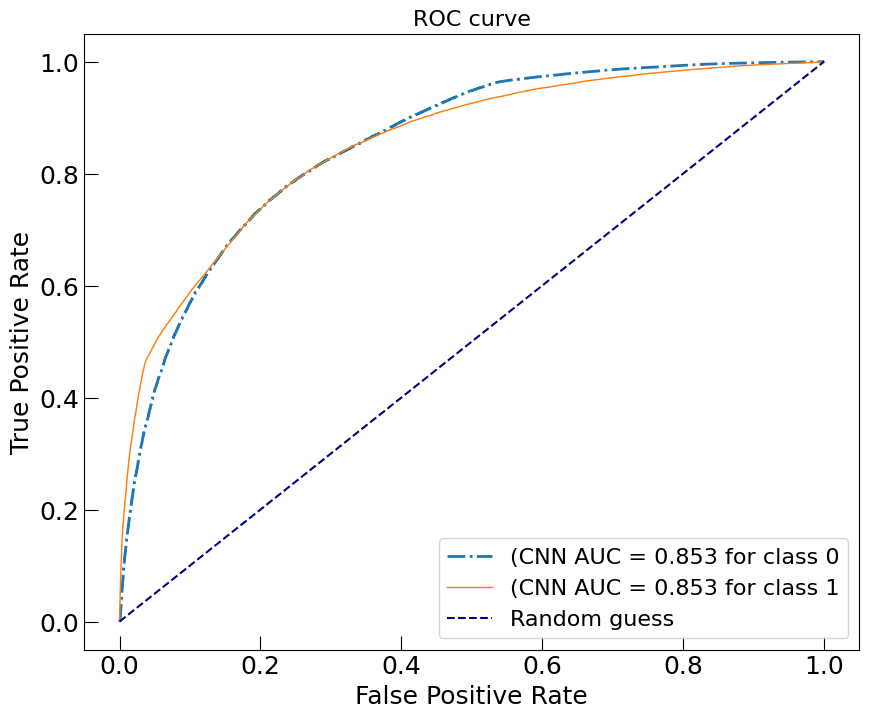

In [31]:
roc_data_cnn = plot_tools.plot_roc_curves(dummy_y_test, predictions_test_numpy, n_classes, linestyles, linewidthss, 'CNN')

Text(0, 0.5, 'True Positive Rate')

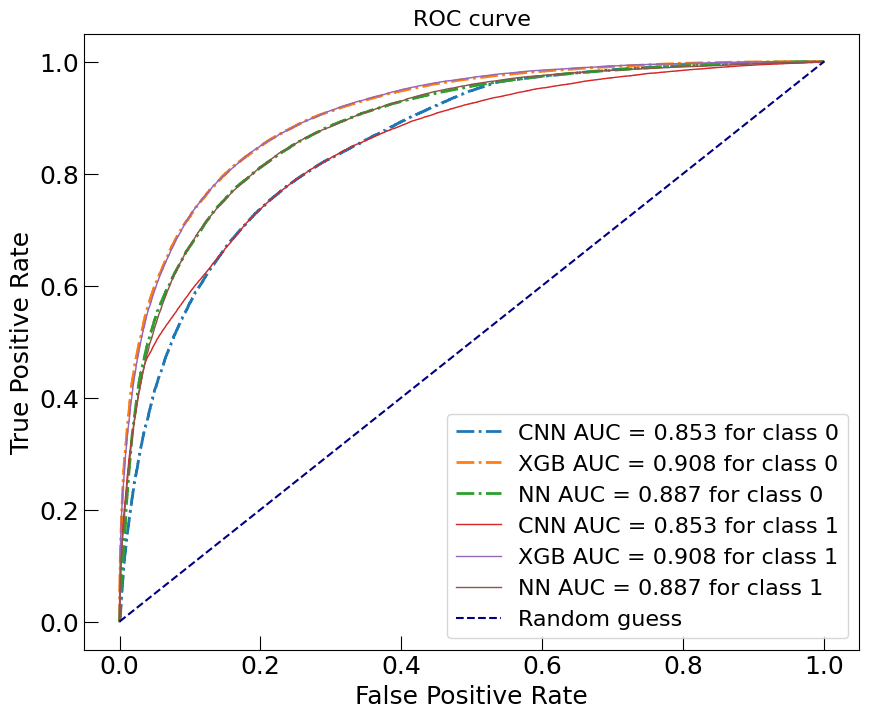

In [32]:
fig, ax =plt.subplots(figsize=(10,8))
for i in range(n_classes):
    plt.plot(roc_data_cnn[i]['fpr'],roc_data_cnn[i]['tpr'],linestyle=linestyles[i],linewidth=linewidthss[i],label=f"CNN AUC = {roc_data_cnn[i]['roc_auc']:0.3f} for class {i}")
    plt.plot(roc_data_xgb[i]['fpr'],roc_data_xgb[i]['tpr'],linestyle=linestyles[i],linewidth=linewidthss[i],label=f"XGB AUC = {roc_data_xgb[i]['roc_auc']:0.3f} for class {i}")
    plt.plot(roc_data[i]['fpr'], roc_data[i]['tpr'],linestyle=linestyles[i],linewidth=linewidthss[i],label=f"NN AUC = {roc_data[i]['roc_auc']:0.3f} for class {i}")


plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random guess')
plt.title("ROC curve", fontsize=16)
plt.legend(loc='lower right',fontsize=16)
ax.tick_params(axis='both', which='major',length=10,direction='in', labelsize=18, zorder=4)
plt.xlabel("False Positive Rate",fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)

In [33]:
%%capture
!pip install numba
from numba import cuda
device = cuda.get_current_device()
device.reset()


## Transformers

In [34]:
x = df_train[new_cuts].copy()
y =df_train['Label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=324, stratify=y)# create a train and a test data set, the train-test will be used for HPO
del x, y

In [35]:
batch_size = 1024
transformer_hyp_par = {
    'd_model': (64, 256),
    'num_heads': (2, 8),
    'num_layers': (2, 15),
    'dropout': (0.1, 0.5),
    'weight_decay': (1e-6, 1e-3),
    'l1_regularization': (1e-6, 1e-3),
    'learning_rate': (1e-5, 1e-2)
}

optimizer = HP_OPT_class_code.HP_OPT(x_train, y_train, batch_size=batch_size, n_trials=20,
                                     transformer_hyp_par=transformer_hyp_par,
                                     num_classes=len(np.unique(y_train)))
study_transformer = optimizer.optimize("transformer")


[I 2023-11-24 16:15:54,146] A new study created in memory with name: no-name-bf33ffde-c672-4dde-a7f7-c1e3ed1dce38
[I 2023-11-24 16:15:54,491] Trial 0 finished with value: 1000.0 and parameters: {'d_model': 236, 'num_heads': 3, 'num_layers': 8, 'dropout': 0.4362414708590988, 'weight_decay': 6.665833619278449e-05, 'l1_regularization': 4.8405899588988825e-06, 'learning_rate': 0.0006062404541864383}. Best is trial 0 with value: 1000.0.
[I 2023-11-24 16:15:56,461] Trial 1 finished with value: 1000.0 and parameters: {'d_model': 159, 'num_heads': 8, 'num_layers': 4, 'dropout': 0.1987239570109247, 'weight_decay': 0.0007548352435344493, 'l1_regularization': 0.00015141127890307878, 'learning_rate': 0.001202913467336033}. Best is trial 0 with value: 1000.0.
[I 2023-11-24 16:15:58,115] Trial 2 finished with value: 1000.0 and parameters: {'d_model': 192, 'num_heads': 5, 'num_layers': 14, 'dropout': 0.4540271360521537, 'weight_decay': 6.4239700355165525e-06, 'l1_regularization': 4.5274650032833745e-

Transformer Best Trial:


In [36]:
# Assuming best_params is obtained from the Optuna study
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_params = study_transformer.best_trial.params

# Instantiate the best transformer model using the hyperparameters
best_model = optimizer.create_transformer_model(
    input_dim=x_train.shape[1],
    num_classes=len(np.unique(y_train)),
    d_model=best_params['d_model'],
    num_heads=best_params['num_heads'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout'],
    weight_decay=best_params['weight_decay'],
    l1_regularization=best_params['l1_regularization']
).to(device)

# Create optimizer and criterion
optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])
criterion = nn.CrossEntropyLoss()

# Number of training epochs
num_epochs = 30
num_workers = 2

X_train, X_valid, Y_train, Y_valid = train_test_split(
            x_train, y_train, test_size=0.2, random_state=324, stratify=y_train
        )
y_train_encoded = encoder.transform(Y_train)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.int64)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
X_valid = scaler.transform(X_valid)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_encoded = encoder.transform(Y_valid)
y_valid_tensor = torch.tensor(y_valid_encoded, dtype=torch.int64)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers)

for epoch in range(num_epochs):
    best_model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs, l1_loss = best_model(inputs)
        loss = criterion(outputs, labels) + l1_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")
best_model.eval()
all_preds = []

with torch.no_grad():
    for data in valid_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs, _ = best_model(inputs)
        all_preds.append(outputs.cpu().numpy())

# Combine predictions from different batches
all_preds = np.concatenate(all_preds, axis=0)

# Assuming you have binary classification, compute ROC AUC
roc_auc = roc_auc_score(y_valid_encoded, all_preds[:, 1])
print(f"Validation ROC AUC: {roc_auc}")


Epoch 1/30, Loss: 0.5353652494294303
Epoch 2/30, Loss: 0.4380908216140708
Epoch 3/30, Loss: 0.42255512123205224
Epoch 4/30, Loss: 0.4121187578658668
Epoch 5/30, Loss: 0.40706281516016746
Epoch 6/30, Loss: 0.40301412374389417
Epoch 7/30, Loss: 0.39898788047080136
Epoch 8/30, Loss: 0.39606387365837487
Epoch 9/30, Loss: 0.3950380162925136
Epoch 10/30, Loss: 0.3940224413360868
Epoch 11/30, Loss: 0.39131663253112714
Epoch 12/30, Loss: 0.39095117060505613
Epoch 13/30, Loss: 0.3889353603732829
Epoch 14/30, Loss: 0.387448184040128
Epoch 15/30, Loss: 0.38572970945007945
Epoch 16/30, Loss: 0.3858955794451188
Epoch 17/30, Loss: 0.384943636400359
Epoch 18/30, Loss: 0.3830868428458973
Epoch 19/30, Loss: 0.3826041708187181
Epoch 20/30, Loss: 0.3828852958216959
Epoch 21/30, Loss: 0.3822831995024973
Epoch 22/30, Loss: 0.38177494461439093
Epoch 23/30, Loss: 0.3808843861429059
Epoch 24/30, Loss: 0.3805354489963882
Epoch 25/30, Loss: 0.3802521320021882
Epoch 26/30, Loss: 0.38003491108514825
Epoch 27/30, 

In [37]:
X_test = scaler.transform(x_test)

# Convert to PyTorch tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(encoder.transform(y_test), dtype=torch.int64)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

best_model.eval()
all_preds_test = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs, _ = best_model(inputs)
        all_preds_test.append(outputs.cpu().numpy())

# Combine predictions from different batches
all_preds_test = np.concatenate(all_preds_test, axis=0)

y_test_encoded = encoder.transform(y_test)
roc_auc_test = roc_auc_score(y_test_encoded, all_preds_test[:, 1])
print(f"Test ROC AUC: {roc_auc_test}")

Test ROC AUC: 0.9051064025701271


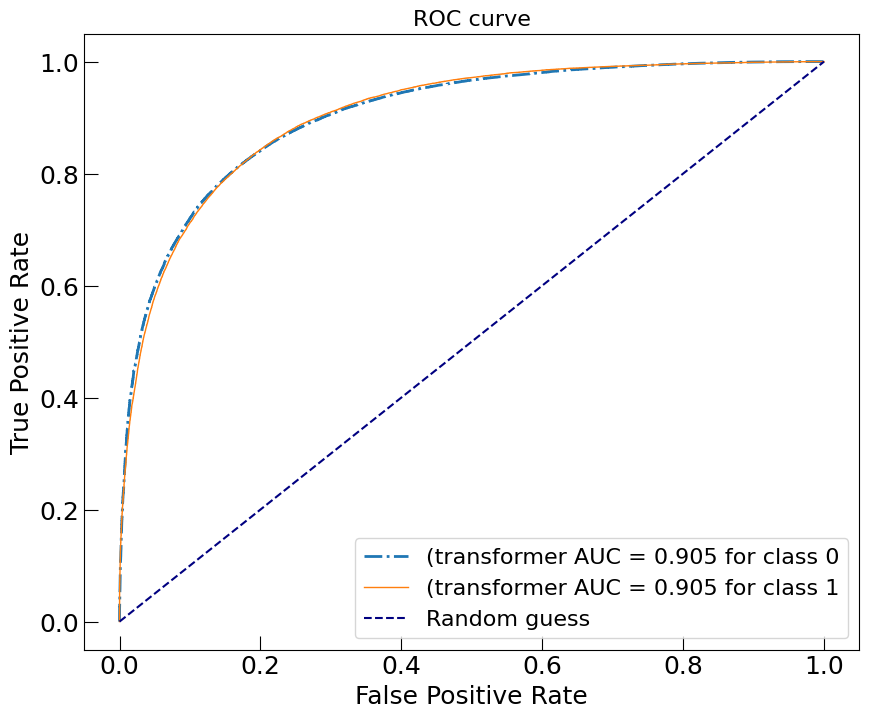

In [38]:
dummy_y_test = np.eye(len(np.unique(y_train)))[y_test_encoded]

# Plot ROC curves
roc_data_trans = plot_tools.plot_roc_curves(dummy_y_test, all_preds_test, n_classes, linestyles, linewidthss, 'transformer')

Text(0, 0.5, 'True Positive Rate')

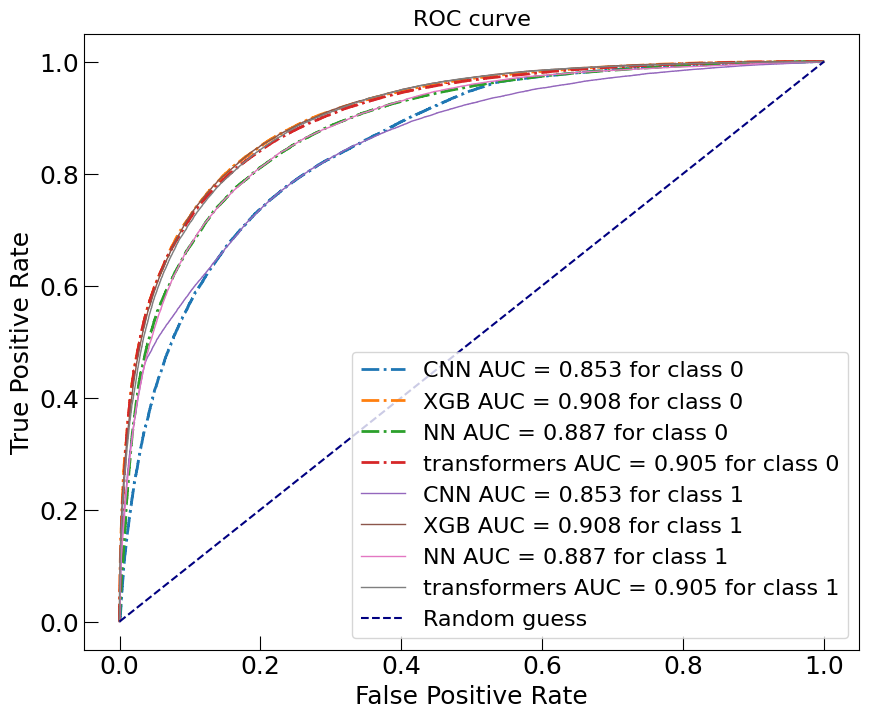

In [39]:
fig, ax =plt.subplots(figsize=(10,8))
for i in range(n_classes):
    plt.plot(roc_data_cnn[i]['fpr'],roc_data_cnn[i]['tpr'],linestyle=linestyles[i],linewidth=linewidthss[i],label=f"CNN AUC = {roc_data_cnn[i]['roc_auc']:0.3f} for class {i}")
    plt.plot(roc_data_xgb[i]['fpr'],roc_data_xgb[i]['tpr'],linestyle=linestyles[i],linewidth=linewidthss[i],label=f"XGB AUC = {roc_data_xgb[i]['roc_auc']:0.3f} for class {i}")
    plt.plot(roc_data[i]['fpr'], roc_data[i]['tpr'],linestyle=linestyles[i],linewidth=linewidthss[i],label=f"NN AUC = {roc_data[i]['roc_auc']:0.3f} for class {i}")
    plt.plot(roc_data_trans[i]['fpr'], roc_data_trans[i]['tpr'],linestyle=linestyles[i],linewidth=linewidthss[i],label=f"transformers AUC = {roc_data_trans[i]['roc_auc']:0.3f} for class {i}")



plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random guess')
plt.title("ROC curve", fontsize=16)
plt.legend(loc='lower right',fontsize=16)
ax.tick_params(axis='both', which='major',length=10,direction='in', labelsize=18, zorder=4)
plt.xlabel("False Positive Rate",fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)

In [45]:
df_train.to_csv(f"{path}/higgs.csv.gz", index=False, sep=';', header=True, compression='gzip')

In [46]:
df_test.to_csv(f"{path}/higgs_test.csv.gz", index=False, sep=';', header=True, compression='gzip')

# Feature engineering
Since the XGBoost algorithm performs better than the other algorithms, now one can also engineer the features.